In [1]:
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from parsedatetime.pdt_locales.fr_FR import ignore

import utils.database as db
import utils.model_evaluation as me

# Evaluating bias under model with higher explanatory power

Prior findings showed correlations between racial and political characteristics of a county and the amount of Paycheck Protection Program funds received, but with [relatively low explanatory power](project_regression_analysis.ipynb) (Adj. R^2 = 0.235). 

The goal of this continued research is to see whether these trends persist after adding further economic controls. Specifically, whether county-level industry composition has an impact on distribution of PPP funds. This is an important control as customer-facing industries like restaurants and entertainment were suddenly and immediately shut down in March 2020. Concentration of these customer-facing industries, in particular, are likely an important control for racial and political characteristics (measured as Republican vote share). 

In [2]:
query = """
    SELECT * EXCLUDE (ppp_loan_amount, total_annual_wages)
    FROM gold.wage_adjusted_ppp_target
"""
df = db.query_df(query)
    
df_clean = df.dropna()

# Check for missingness
assert len(df) == len(df_clean), 'Design matrix has missing values to remove'
display(df.describe())
df.head()

yoy_job_change_pct  wage_adjusted_ppp_loan_amount  white_pop_share  \
count         3102.000000                    3102.000000      3102.000000   
mean             0.004907                       0.188088         0.846663   
std              0.046776                       0.146931         0.159094   
min             -0.698834                       0.002552         0.080279   
25%             -0.011261                       0.117098         0.798526   
50%              0.005441                       0.151997         0.913437   
75%              0.022076                       0.211278         0.954372   
max              0.387097                       2.668559         0.990350   

       black_pop_share  asian_pop_share  native_pop_share  hispanic_share  \
count      3102.000000      3102.000000       3102.000000     3102.000000   
mean          0.094348         0.015609          0.022171        0.098232   
std           0.145067         0.029409          0.065549        0.139381   
min           0.000000         0.000000          0.000000        0.006478   
25%           0.008935         0.004771          0.004549        0.024585   
50%           0.026032         0.007463          0.007584        0.044783   
75%           0.110353         0.014364          0.015041        0.101954   
max           0.865932         0.433623          0.867643        0.963533   

       trump_share  accommodation_and_food_services_wage_share  \
count  3102.000000                                 3102.000000   
mean      0.632285                                    0.039998   
std       0.156691                                    0.044082   
min       0.040875                                    0.000000   
25%       0.544628                                    0.013833   
50%       0.663140                                    0.034584   
75%       0.748781                                    0.051487   
max       0.945848                                    0.550845   

       accommodation_and_food_services_job_loc_quotient  ...  \
count                                       3102.000000  ...   
mean                                           0.767231  ...   
std                                            0.579438  ...   
min                                            0.000000  ...   
25%                                            0.360000  ...   
50%                                            0.820000  ...   
75%                                            1.070000  ...   
max                                            5.080000  ...   

       retail_trade_wage_share  retail_trade_job_loc_quotient  \
count              3102.000000                    3102.000000   
mean                  0.099707                       1.069855   
std                   0.045100                       0.341253   
min                   0.000000                       0.000000   
25%                   0.072031                       0.880000   
50%                   0.094869                       1.080000   
75%                   0.123047                       1.260000   
max                   0.394177                       3.170000   

       transportation_and_warehousing_wage_share  \
count                                3102.000000   
mean                                    0.036751   
std                                     0.049376   
min                                     0.000000   
25%                                     0.000000   
50%                                     0.024795   
75%                                     0.050969   
max                                     0.688991   

       transportation_and_warehousing_job_loc_quotient  \
count                                      3102.000000   
mean                                          0.690538   
std                                           0.922990   
min                                           0.000000   
25%                                           0.000000   
50%                                         

county     state urbanicity  yoy_job_change_pct  \
0  Appomattox County  Virginia      urban           -0.016036   
1   Arlington County  Virginia      urban            0.026394   
2       Giles County  Virginia      urban           -0.025776   
3     Grayson County  Virginia      rural            0.121393   
4    Richmond County  Virginia      rural           -0.001100   

   wage_adjusted_ppp_loan_amount  white_pop_share  black_pop_share  \
0                       0.172092         0.786940         0.185469   
1                       0.059148         0.750032         0.096782   
2                       0.069858         0.962739         0.015969   
3                       0.160522         0.924823         0.057428   
4                       0.170235         0.667516         0.296465   

   asian_pop_share  native_pop_share  hispanic_share  ...  \
0         0.003834          0.003520        0.018855  ...   
1         0.109546          0.007769        0.156015  ...   
2         0.005801          0.002990        0.018361  ...   
3         0.002058          0.003601        0.038264  ...   
4         0.007093          0.006096        0.072925  ...   

   retail_trade_wage_share  retail_trade_job_loc_quotient  \
0                 0.225276                           1.94   
1                 0.024007                           0.49   
2                 0.103267                           1.30   
3                 0.057088                           0.51   
4                 0.074205                           0.79   

   transportation_and_warehousing_wage_share  \
0                                   0.000000   
1                                   0.064589   
2                                   0.019956   
3                                   0.015953   
4                                   0.000000   

   transportation_and_warehousing_job_loc_quotient  unclassified_wage_share  \
0                                             0.00                 0.003127   
1                                             1.40                 0.001434   
2                                             0.41                 0.001315   
3                                             0.23                 0.000000   
4                                             0.00                 0.000000   

   unclassified_job_loc_quotient  utilities_wage_share  \
0                           2.79              0.000000   
1                           1.60              0.011543   
2                           1.50              0.000000   
3                           0.00              0.000000   
4                           0.00              0.000000   

   utilities_job_loc_quotient  wholesale_trade_wage_share  \
0                        0.00                    0.036170   
1                        0.53                    0.017317   
2                        0.00                    0.000000   
3                        0.00                    0.000000   
4                        0.00                    0.074327   

   wholesale_trade_job_loc_quotient  
0                              0.47  
1                              0.22  
2                              0.00  
3                              0.00  
4                              1.13  

[5 rows x 51 columns]

## Evaluate correlations of numerical variables

Exclude all location quotient information for direct covariance with wage share. Keep wage share to prefer trends in local economic makeup, rather than relation to national economy indicated by loc quotient. 

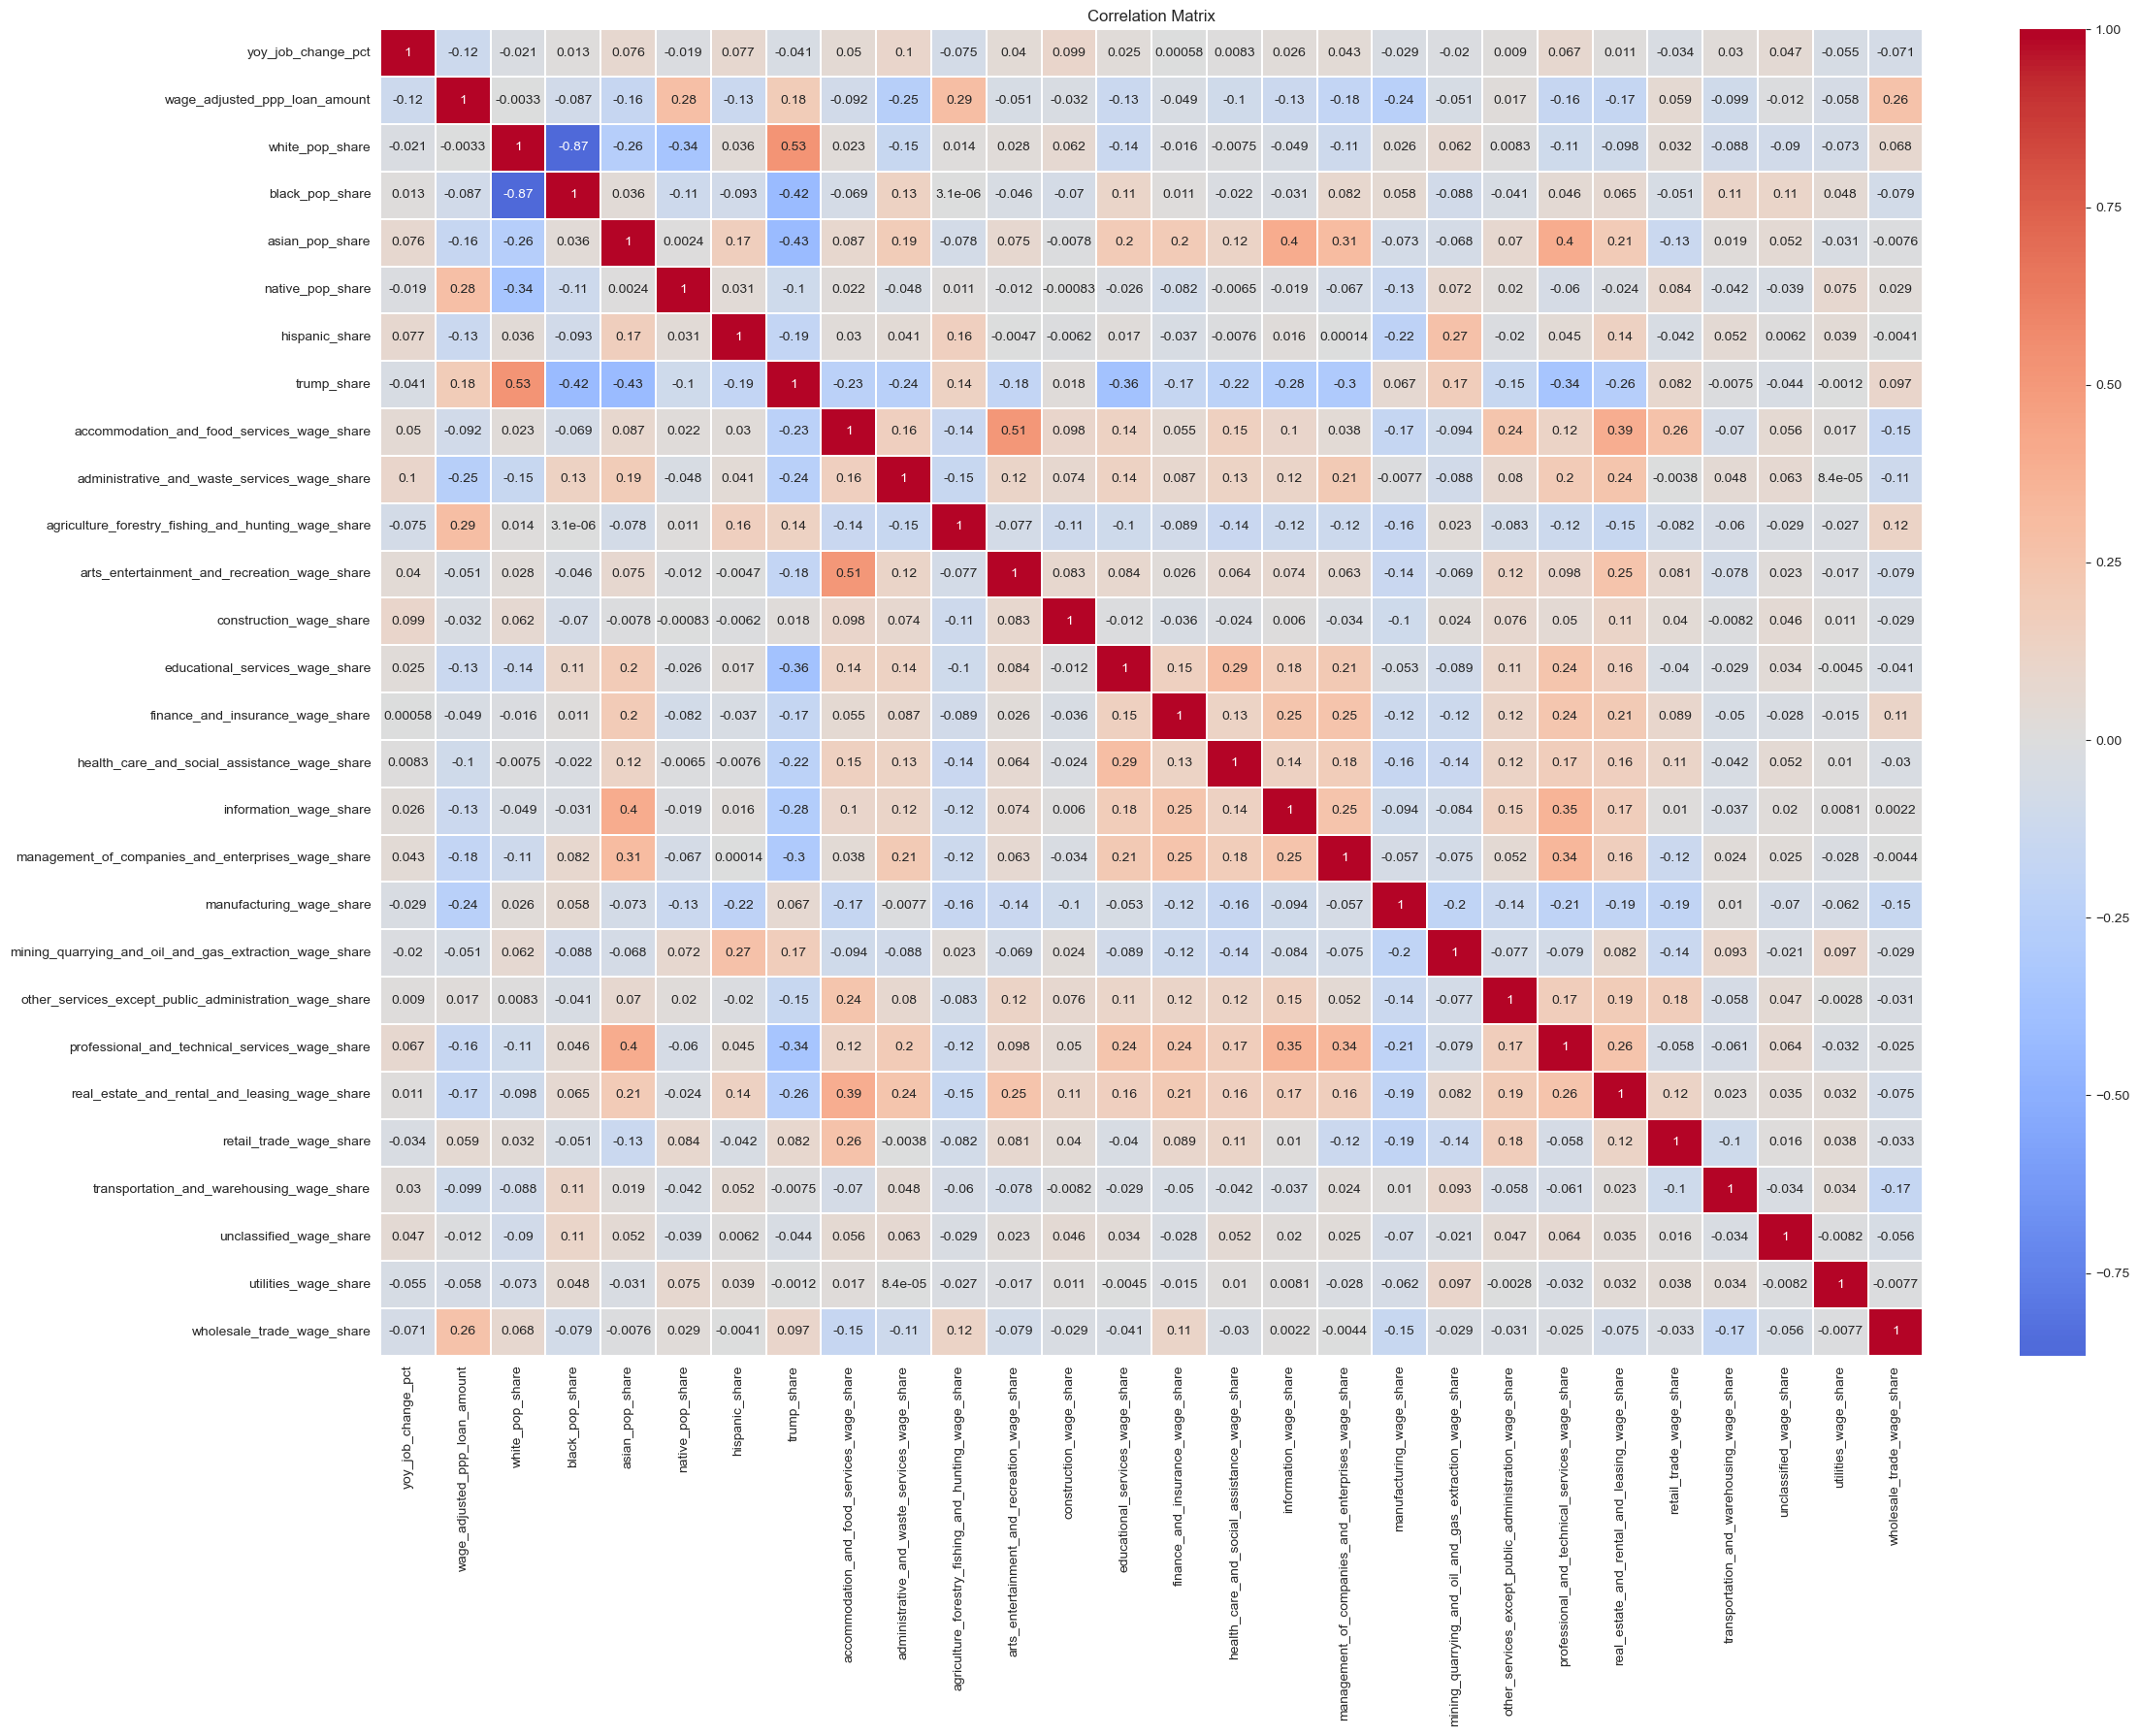

In [3]:
fig_size = (24, 18)
no_loc_df = df[[c for c in df.columns if '_loc_' not in c]]
me.plot_correlation_matrix(data=no_loc_df, fig_size=fig_size, annot=True)

## Evaluate regression on all features

Evaluate regression against full model. 

In [4]:
target = 'wage_adjusted_ppp_loan_amount'

base_model_spec = {
    'target': f'np.log({target})',
    'data': no_loc_df,
    'exclusion_set': None,
    'cat_var_set': set(["C(urbanicity, Treatment(reference='urban'))"])
}

base_model_formula = me.generate_formula_string(**base_model_spec)
base_model = smf.ols(base_model_formula, data=df).fit()

me.evaluate_vifs(base_model)

Feature          VIF
0                                           Intercept  2170.770258
28                    np.power(white_pop_share, 0.25)     5.331395
8                     np.power(black_pop_share, 0.25)     4.419277
6   np.power(arts_entertainment_and_recreation_wag...     4.118054
10    np.power(educational_services_wage_share, 0.25)     3.836354
3   np.power(accommodation_and_food_services_wage_...     3.541712
21  np.power(real_estate_and_rental_and_leasing_wa...     3.359918
15  np.power(management_of_companies_and_enterpris...     2.946037
24                        np.power(trump_share, 0.25)     2.646298
7                     np.power(asian_pop_share, 0.25)     2.451524
14             np.power(information_wage_share, 0.25)     2.423367
1   C(urbanicity, Treatment(reference='urban'))[T....     2.280522
11   np.power(finance_and_insurance_wage_share, 0.25)     2.259092
18                   np.power(native_pop_share, 0.25)     2.116579
12  np.power(health_care_and_social_assistance_wag...     2.102114
13                     np.power(hispanic_share, 0.25)     1.955029
26               np.power(utilities_wage_share, 0.25)     1.938289
20  np.power(professional_and_technical_services_w...     1.862653
4   np.power(administrative_and_waste_services_wag...     1.804885
27      np.power(wage_adjusted_ppp_loan_amount, 0.25)     1.730974
23  np.power(transportation_and_warehousing_wage_s...     1.684546
2   C(urbanicity, Treatment(reference='urban'))[T....     1.655071
19  np.power(other_services_except_public_administ...     1.617411
17  np.power(mining_quarrying_and_oil_and_gas_extr...     1.588654
29         np.power(wholesale_trade_wage_share, 0.25)     1.554951
16           np.power(manufacturing_wage_share, 0.25)     1.539868
9             np.power(construction_wage_share, 0.25)     1.484709
22            np.power(retail_trade_wage_share, 0.25)     1.403389
5   np.power(agriculture_forestry_fishing_and_hunt...     1.399783
25            np.power(unclassified_wage_share, 0.25)     1.256600
30                 np.power(yoy_job_change_pct, 0.25)     1.241286

# Address multi-collinearity

Remove specific demographic variables to reduce multi-collinearity in demographic and political variables. Start by removing white share, seeing covariance matrix trend between white population and Trump share and stronger correlation between target and black population share.  

In [5]:
m_col_model_spec = {
    'target': f'np.log({target})',
    'data': no_loc_df,
    'exclusion_set': set(['white_pop_share']),
    'cat_var_set': set(["C(urbanicity, Treatment(reference='urban'))"])
}

m_col_formula = me.generate_formula_string(**m_col_model_spec)
m_col_model = smf.ols(m_col_formula, data=df).fit()

me.evaluate_vifs(m_col_model)

Feature          VIF
0                                           Intercept  2170.770258
28                    np.power(white_pop_share, 0.25)     5.331395
8                     np.power(black_pop_share, 0.25)     4.419277
6   np.power(arts_entertainment_and_recreation_wag...     4.118054
10    np.power(educational_services_wage_share, 0.25)     3.836354
3   np.power(accommodation_and_food_services_wage_...     3.541712
21  np.power(real_estate_and_rental_and_leasing_wa...     3.359918
15  np.power(management_of_companies_and_enterpris...     2.946037
24                        np.power(trump_share, 0.25)     2.646298
7                     np.power(asian_pop_share, 0.25)     2.451524
14             np.power(information_wage_share, 0.25)     2.423367
1   C(urbanicity, Treatment(reference='urban'))[T....     2.280522
11   np.power(finance_and_insurance_wage_share, 0.25)     2.259092
18                   np.power(native_pop_share, 0.25)     2.116579
12  np.power(health_care_and_social_assistance_wag...     2.102114
13                     np.power(hispanic_share, 0.25)     1.955029
26               np.power(utilities_wage_share, 0.25)     1.938289
20  np.power(professional_and_technical_services_w...     1.862653
4   np.power(administrative_and_waste_services_wag...     1.804885
27      np.power(wage_adjusted_ppp_loan_amount, 0.25)     1.730974
23  np.power(transportation_and_warehousing_wage_s...     1.684546
2   C(urbanicity, Treatment(reference='urban'))[T....     1.655071
19  np.power(other_services_except_public_administ...     1.617411
17  np.power(mining_quarrying_and_oil_and_gas_extr...     1.588654
29         np.power(wholesale_trade_wage_share, 0.25)     1.554951
16           np.power(manufacturing_wage_share, 0.25)     1.539868
9             np.power(construction_wage_share, 0.25)     1.484709
22            np.power(retail_trade_wage_share, 0.25)     1.403389
5   np.power(agriculture_forestry_fishing_and_hunt...     1.399783
25            np.power(unclassified_wage_share, 0.25)     1.256600
30                 np.power(yoy_job_change_pct, 0.25)     1.241286

## Multi-collineary adjustment results

Removing white vote share addressed multi-collinearity sufficiently to proceed with control model analysis of demographic trends against industry totals. 

bp_stat: 226.44909347045794 | bp_pvalue: 4.996686346444783e-32


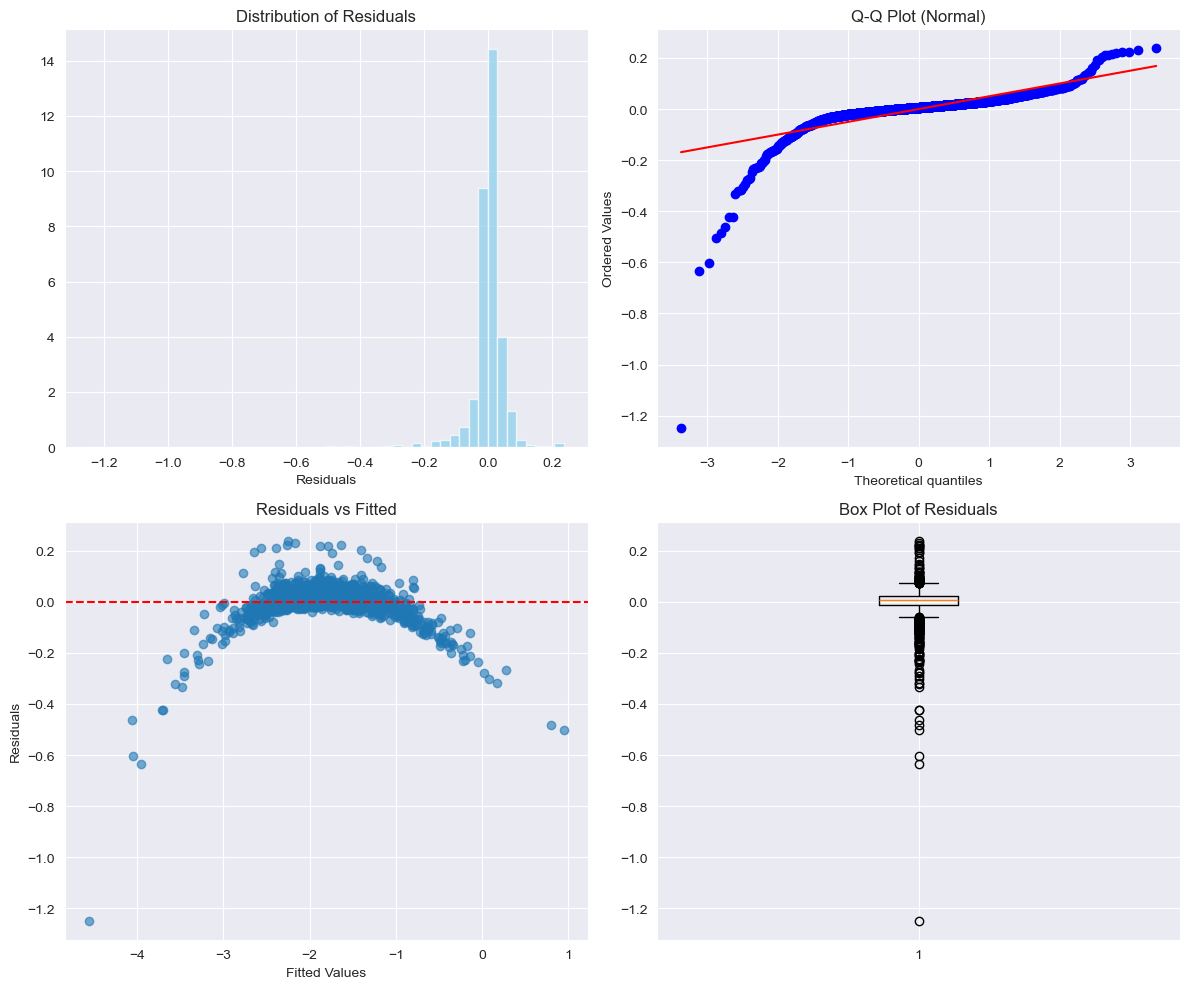

In [6]:
me.test_model_assumptions(m_col_model)

## Model shows strong heteroscedacity

Violates assumption of normally distributed residuals, making p-values unreliable. Investigating robust standard errors for improvements.  

In [7]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

def test_individual_variable_heteroscedasticity(df, target_var, predictors):
    """Test each predictor individually for heteroscedasticity"""
    
    individual_results = {}
    
    print("INDIVIDUAL VARIABLE HETEROSCEDASTICITY ANALYSIS")
    print("=" * 60)
    
    for predictor in predictors:
        if predictor in df.columns:
            print(f"\nTesting: {predictor}")
            print("-" * 40)
            
            # Simple bivariate model
            if predictor.startswith('C('):  # Categorical variable
                formula = f"{target_var} ~ {predictor}"
            else:
                formula = f"{target_var} ~ {predictor}"
            
            try:
                # Fit simple model
                simple_model = smf.ols(formula, data=df).fit()
                
                # Test for heteroscedasticity
                bp_stat, bp_pvalue, _, _ = het_breuschpagan(simple_model.resid, simple_model.model.exog)
                white_stat, white_pvalue, _, _ = het_white(simple_model.resid, simple_model.model.exog)
                
                # Additional diagnostics
                residuals = simple_model.resid
                fitted = simple_model.fittedvalues
                
                # Correlation between |residuals| and fitted values
                abs_resid_fitted_corr = np.corrcoef(np.abs(residuals), fitted)[0, 1]
                
                # Correlation between residuals² and predictor values
                if not predictor.startswith('C('):
                    resid_sq_pred_corr = np.corrcoef(residuals**2, df[predictor])[0, 1]
                else:
                    resid_sq_pred_corr = np.nan
                
                # Variance across predictor ranges
                if not predictor.startswith('C('):
                    df_temp = pd.DataFrame({'pred': df[predictor], 'resid': residuals})
                    df_temp['quintile'] = pd.qcut(df_temp['pred'], 5, labels=False, duplicates='drop')
                    quintile_vars = df_temp.groupby('quintile')['resid'].var()
                    variance_ratio = quintile_vars.max() / quintile_vars.min() if quintile_vars.min() > 0 else np.inf
                else:
                    variance_ratio = np.nan
                
                individual_results[predictor] = {
                    'bp_statistic': bp_stat,
                    'bp_pvalue': bp_pvalue,
                    'white_pvalue': white_pvalue,
                    'r_squared': simple_model.rsquared,
                    'abs_resid_fitted_corr': abs_resid_fitted_corr,
                    'resid_sq_pred_corr': resid_sq_pred_corr,
                    'variance_ratio': variance_ratio,
                    'heteroscedastic': bp_pvalue < 0.05,
                    'het_severity': 'High' if bp_pvalue < 0.001 else 'Moderate' if bp_pvalue < 0.05 else 'Low'
                }
                
                print(f"  BP test p-value: {bp_pvalue:.6f} ({'HETEROSCEDASTIC' if bp_pvalue < 0.05 else 'Homoscedastic'})")
                print(f"  White test p-value: {white_pvalue:.6f}")
                print(f"  R²: {simple_model.rsquared:.3f}")
                print(f"  |Residual|-Fitted correlation: {abs_resid_fitted_corr:.3f}")
                if not np.isnan(resid_sq_pred_corr):
                    print(f"  Residual²-Predictor correlation: {resid_sq_pred_corr:.3f}")
                if not np.isnan(variance_ratio):
                    print(f"  Variance ratio across ranges: {variance_ratio:.2f}")
                
            except Exception as e:
                print(f"  Error testing {predictor}: {e}")
                individual_results[predictor] = {'error': str(e)}
    
    # Summary of results
    valid_results = {k: v for k, v in individual_results.items() if 'error' not in v}
    
    # Rank by heteroscedasticity severity
    heteroscedastic_vars = [(k, v) for k, v in valid_results.items() if v['heteroscedastic']]
    heteroscedastic_vars.sort(key=lambda x: x[1]['bp_pvalue'])  # Sort by p-value (ascending)
    
    print(f"\n" + "="*60)
    print("SUMMARY: Variables causing heteroscedasticity (worst first):")
    print("="*60)
    
    for var, stats in heteroscedastic_vars:
        print(f"  {var}:")
        print(f"    BP p-value: {stats['bp_pvalue']:.6f} ({stats['het_severity']})")
        print(f"    Variance ratio: {stats['variance_ratio']:.2f}")
        print(f"    R²: {stats['r_squared']:.3f}")
    
    if len(heteroscedastic_vars) == 0:
        print("  ✅ No individual variables show strong heteroscedasticity")
        print("     → Heteroscedasticity likely comes from variable interactions")
    
    return individual_results, heteroscedastic_vars

# Test your variables individually
predictors_to_test = no_loc_df.select_dtypes(include=[np.number]).columns.to_list()

individual_het_results, het_vars = test_individual_variable_heteroscedasticity(
    no_loc_df, 'wage_adjusted_ppp_loan_amount', predictors_to_test
)

INDIVIDUAL VARIABLE HETEROSCEDASTICITY ANALYSIS

Testing: yoy_job_change_pct
----------------------------------------
  BP test p-value: 0.001776 (HETEROSCEDASTIC)
  White test p-value: 0.004198
  R²: 0.014
  |Residual|-Fitted correlation: 0.113
  Residual²-Predictor correlation: -0.056
  Variance ratio across ranges: 7.91

Testing: wage_adjusted_ppp_loan_amount
----------------------------------------
  BP test p-value: 0.000000 (HETEROSCEDASTIC)
  White test p-value: 0.000000
  R²: 1.000
  |Residual|-Fitted correlation: 0.639
  Residual²-Predictor correlation: 0.690
  Variance ratio across ranges: 774.03

Testing: white_pop_share
----------------------------------------
  BP test p-value: 0.000007 (HETEROSCEDASTIC)
  White test p-value: 0.000000
  R²: 0.000
  |Residual|-Fitted correlation: 0.056
  Residual²-Predictor correlation: -0.081
  Variance ratio across ranges: 9.16

Testing: black_pop_share
----------------------------------------
  BP test p-value: 0.024157 (HETEROSCEDASTIC)

bp_stat: 8.491913464681033e-05 | bp_pvalue: 0.9926474718686668


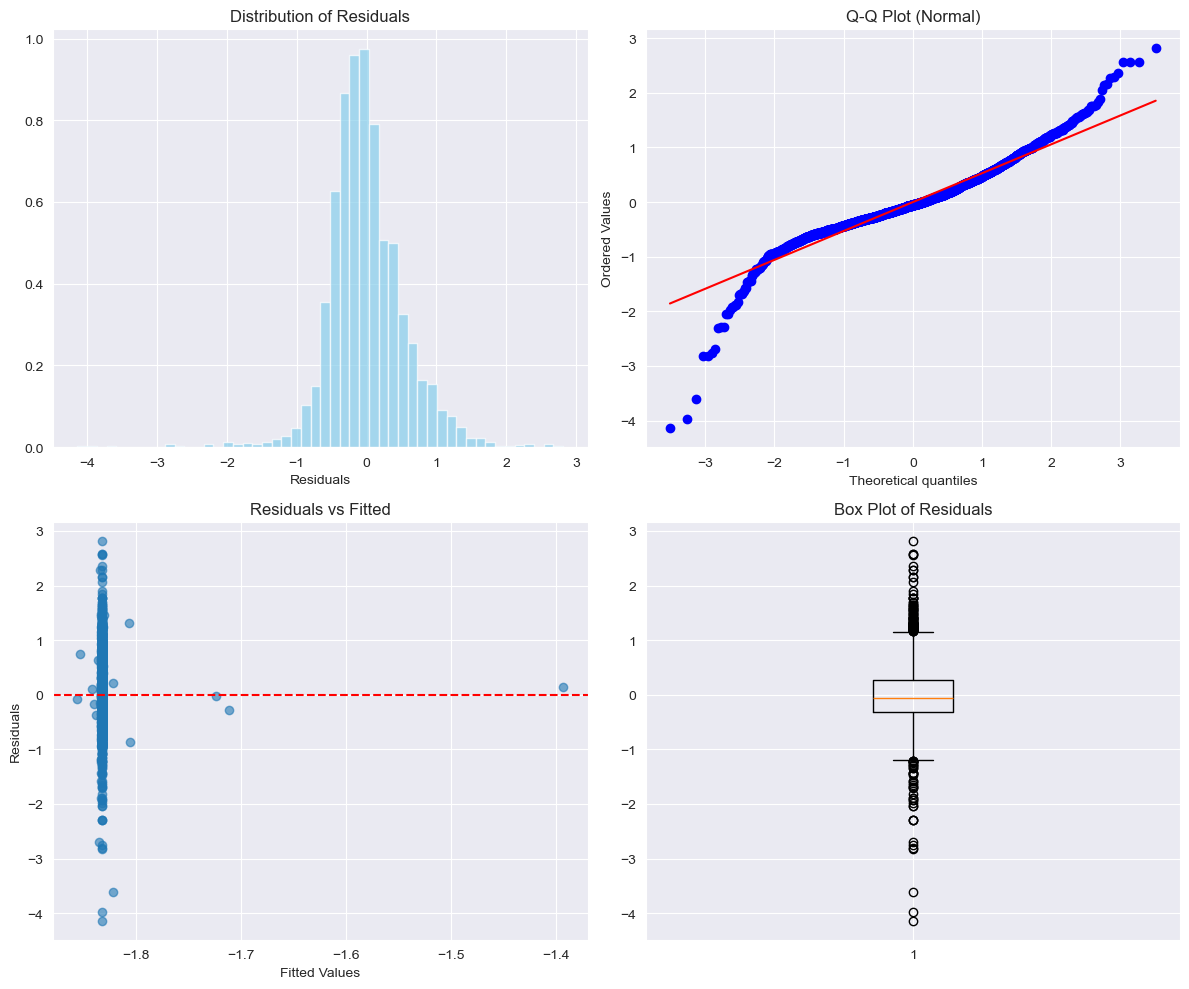

In [8]:
t_model = smf.ols(f'np.log(wage_adjusted_ppp_loan_amount) ~ np.power(yoy_job_change_pct, 5)', data=df).fit(cov_type='HC3')
me.test_model_assumptions(t_model)

Evaluating bp_stat for: yoy_job_change_pct
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


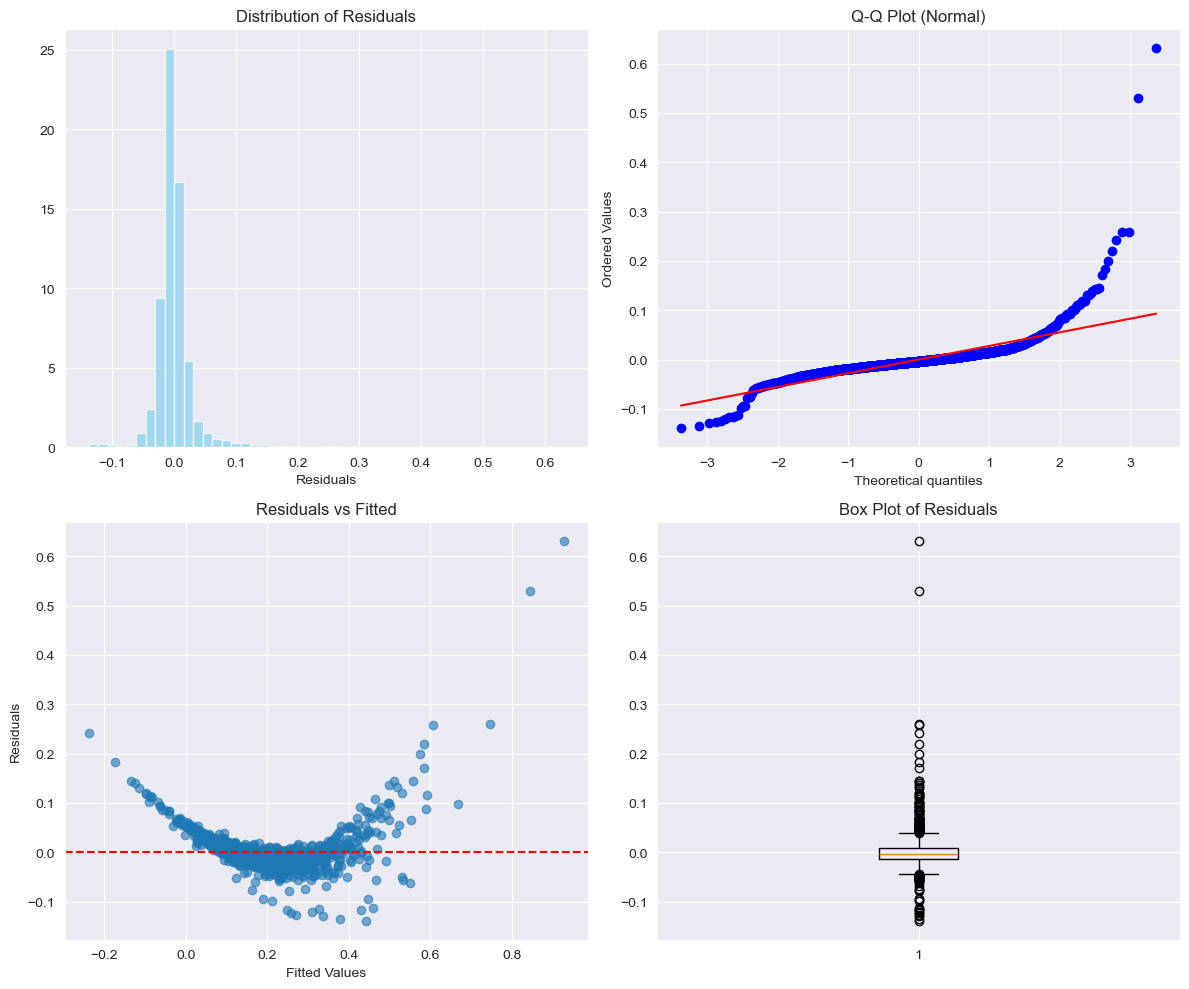

Evaluating bp_stat for: white_pop_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


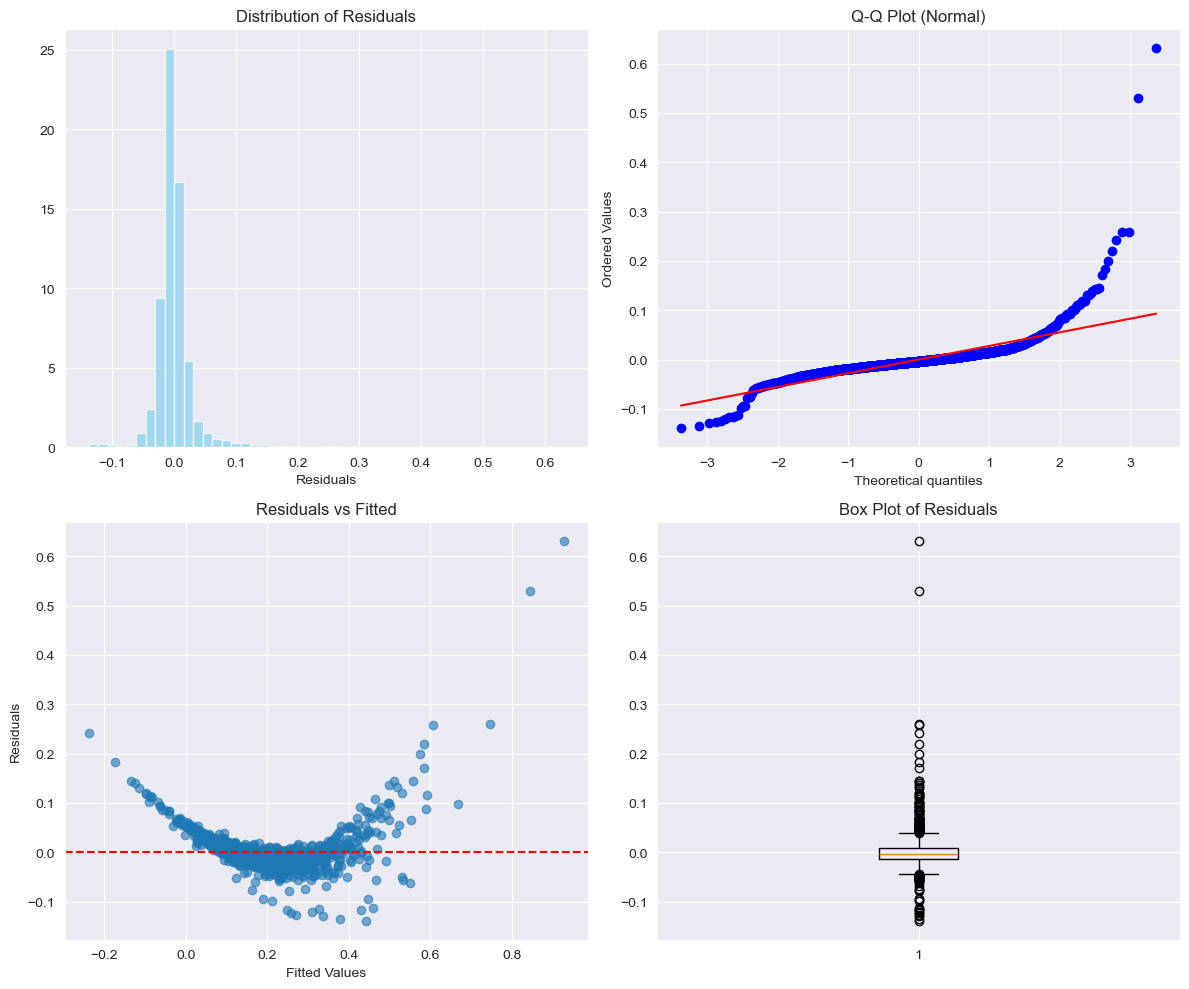

Evaluating bp_stat for: black_pop_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


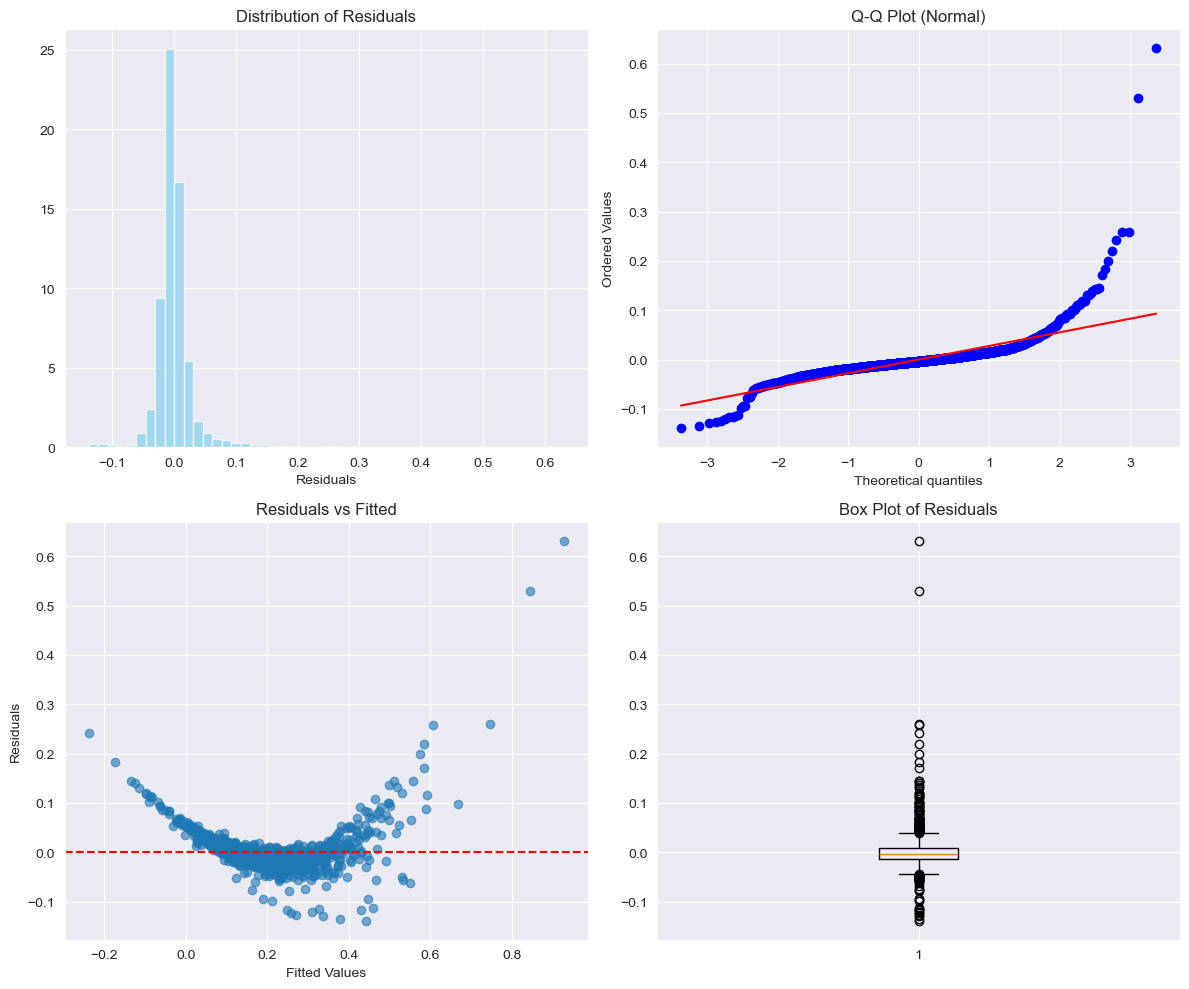

Evaluating bp_stat for: asian_pop_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


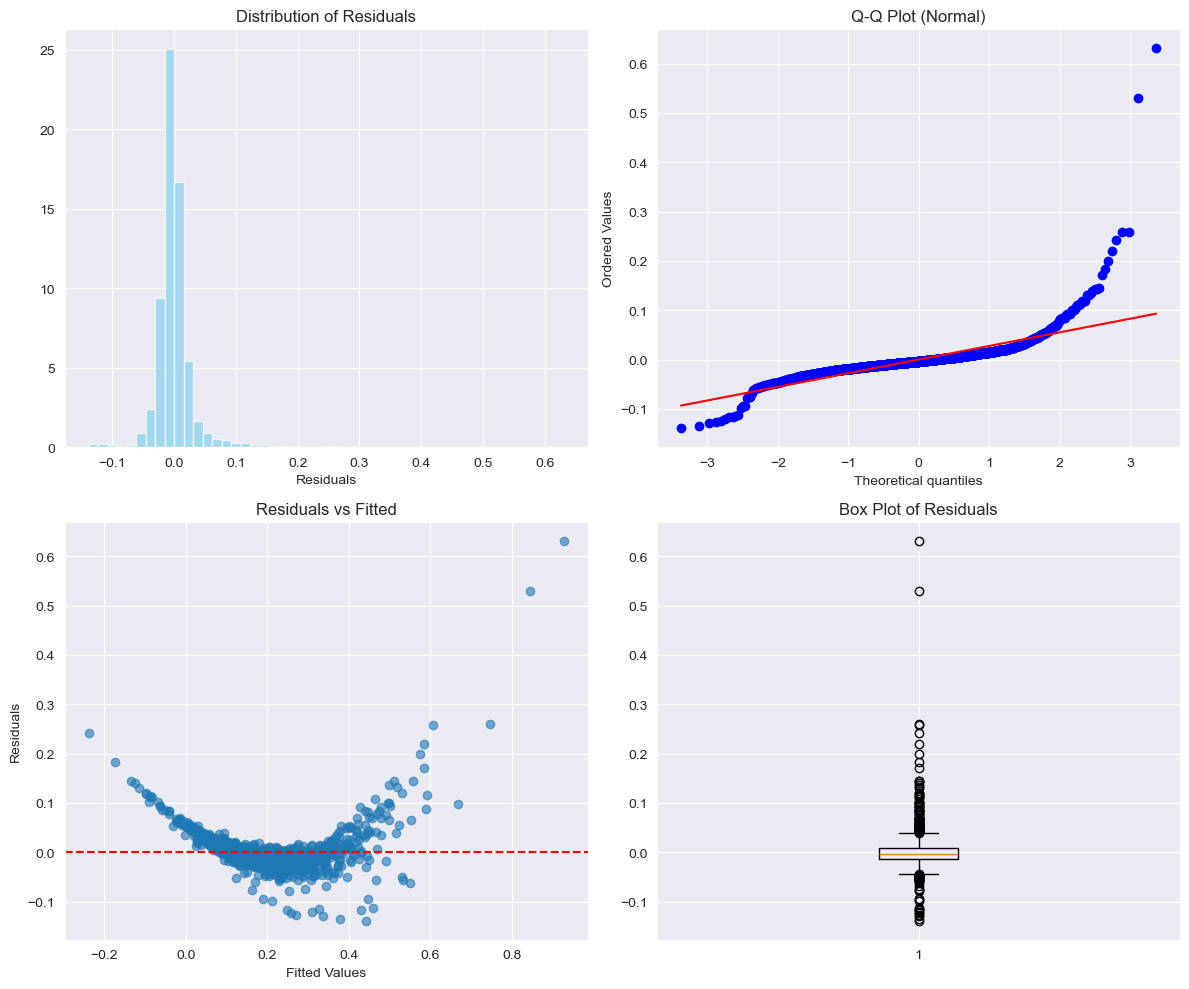

Evaluating bp_stat for: native_pop_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


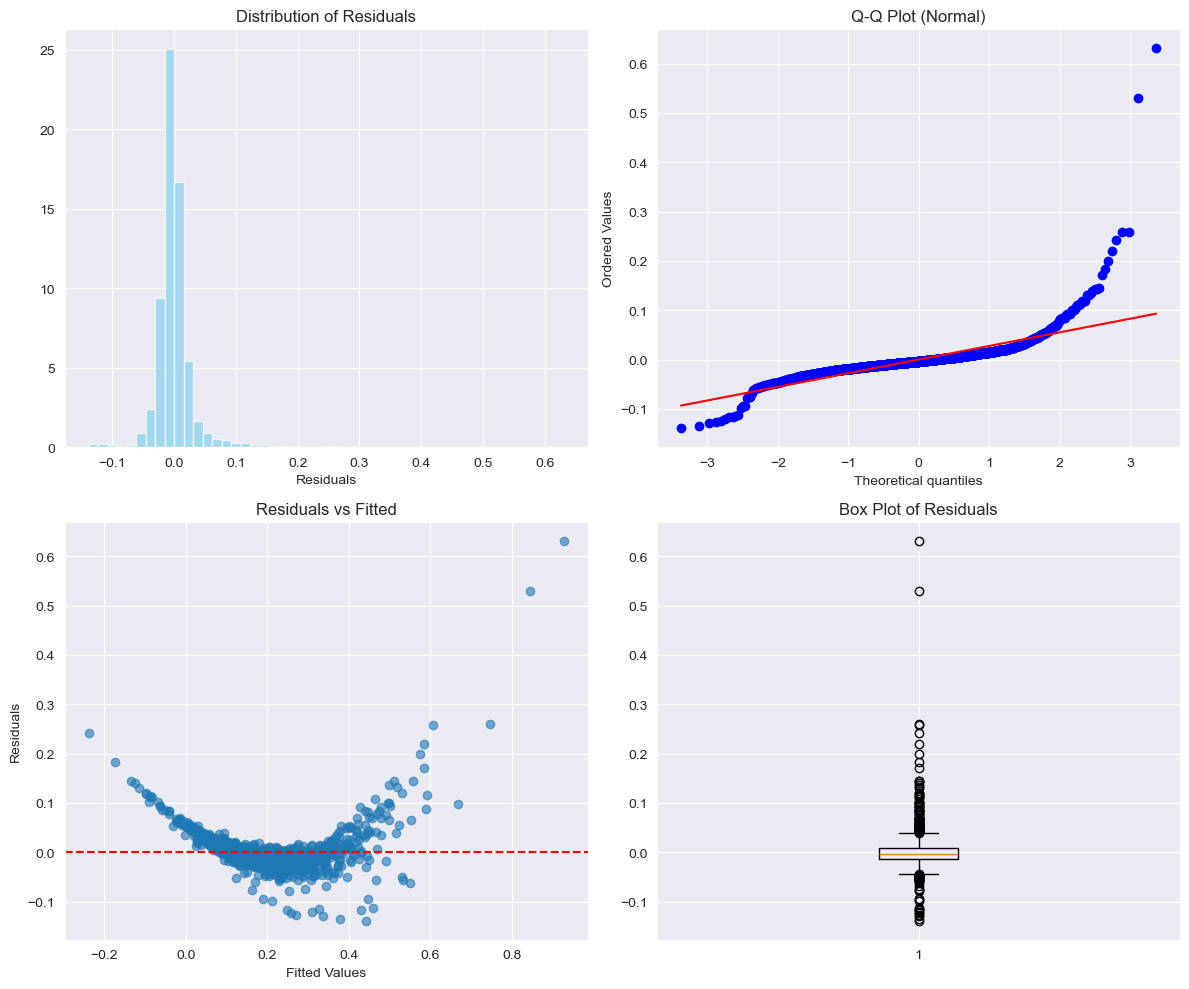

Evaluating bp_stat for: hispanic_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


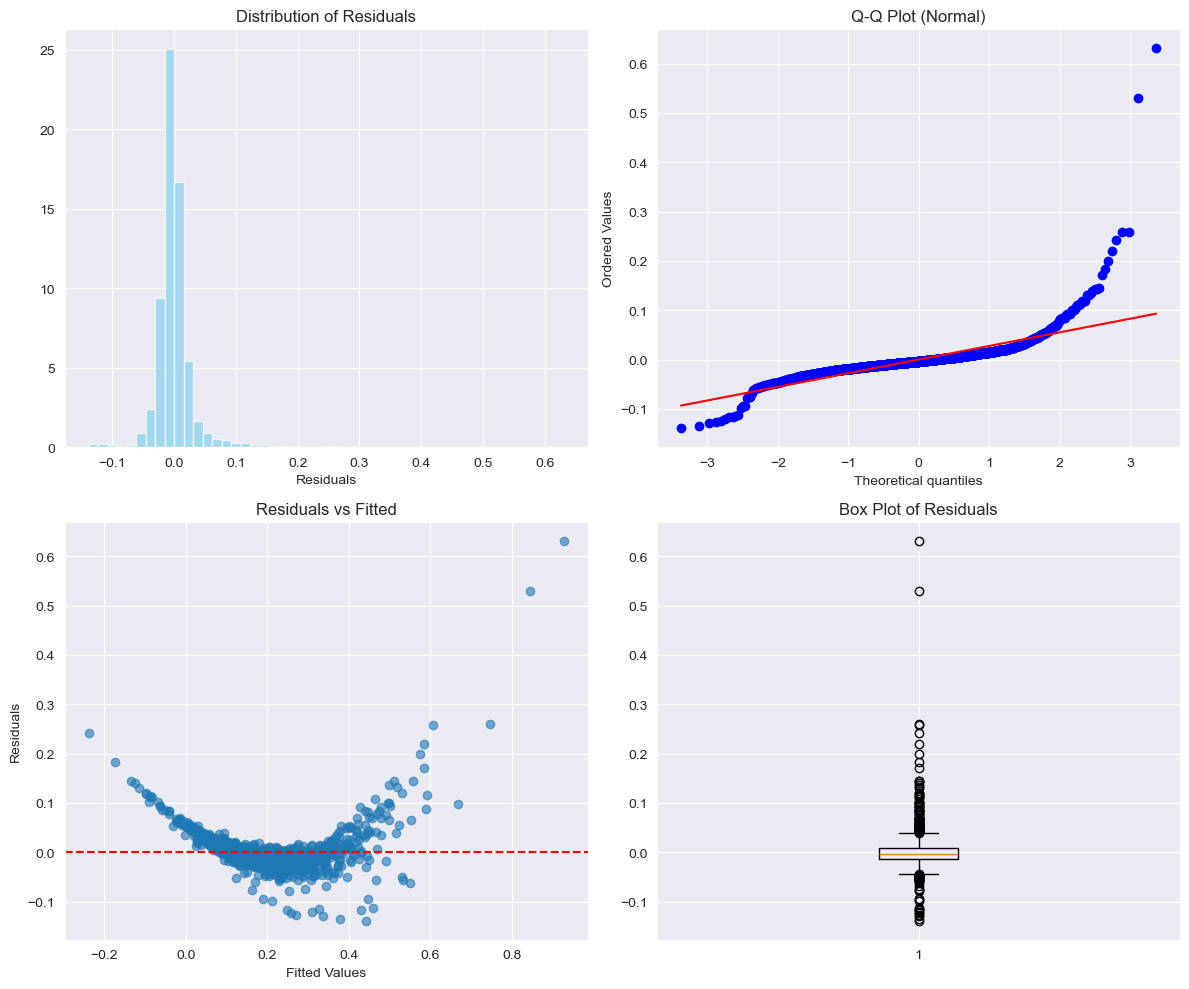

Evaluating bp_stat for: trump_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


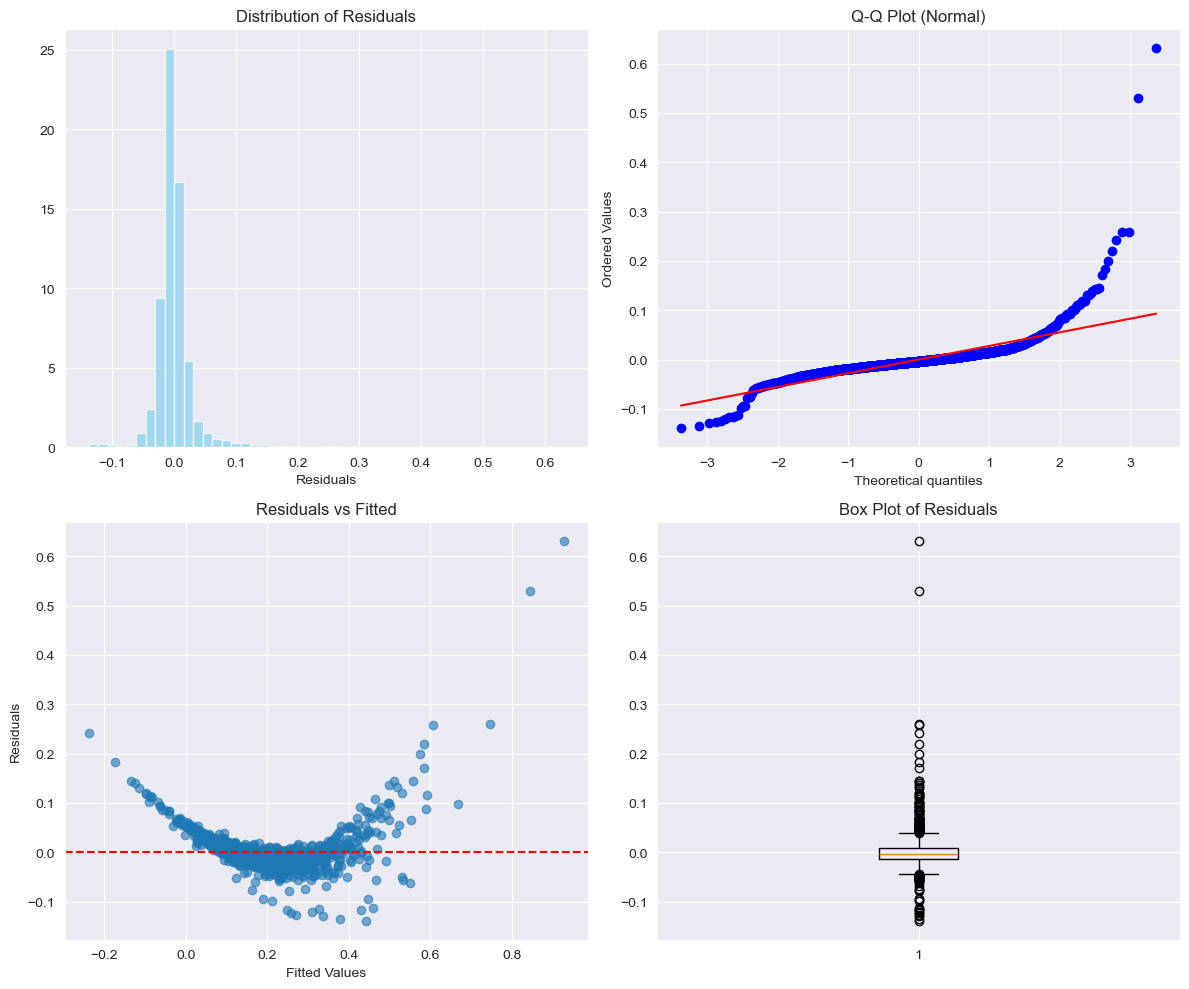

Evaluating bp_stat for: accommodation_and_food_services_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


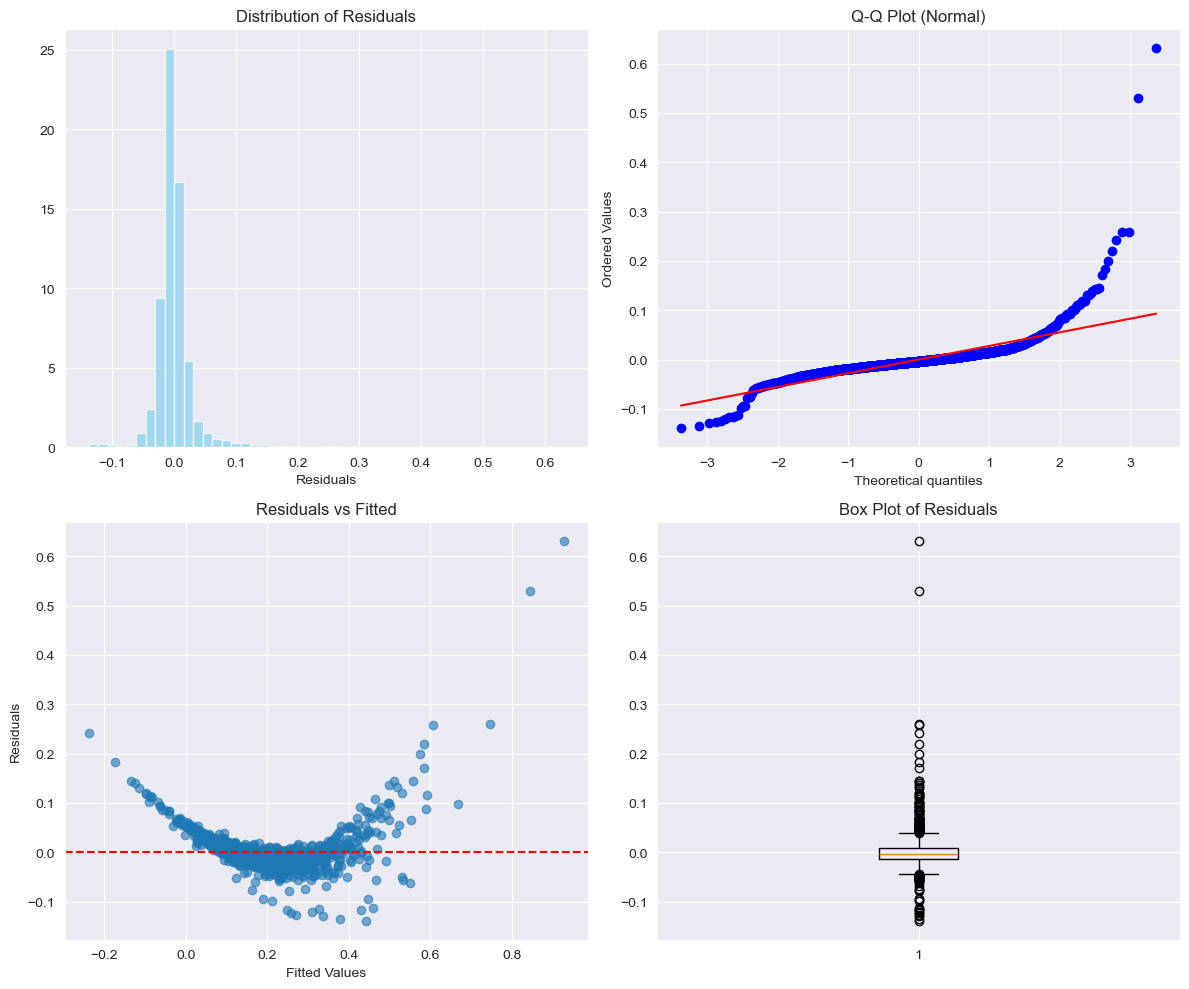

Evaluating bp_stat for: administrative_and_waste_services_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


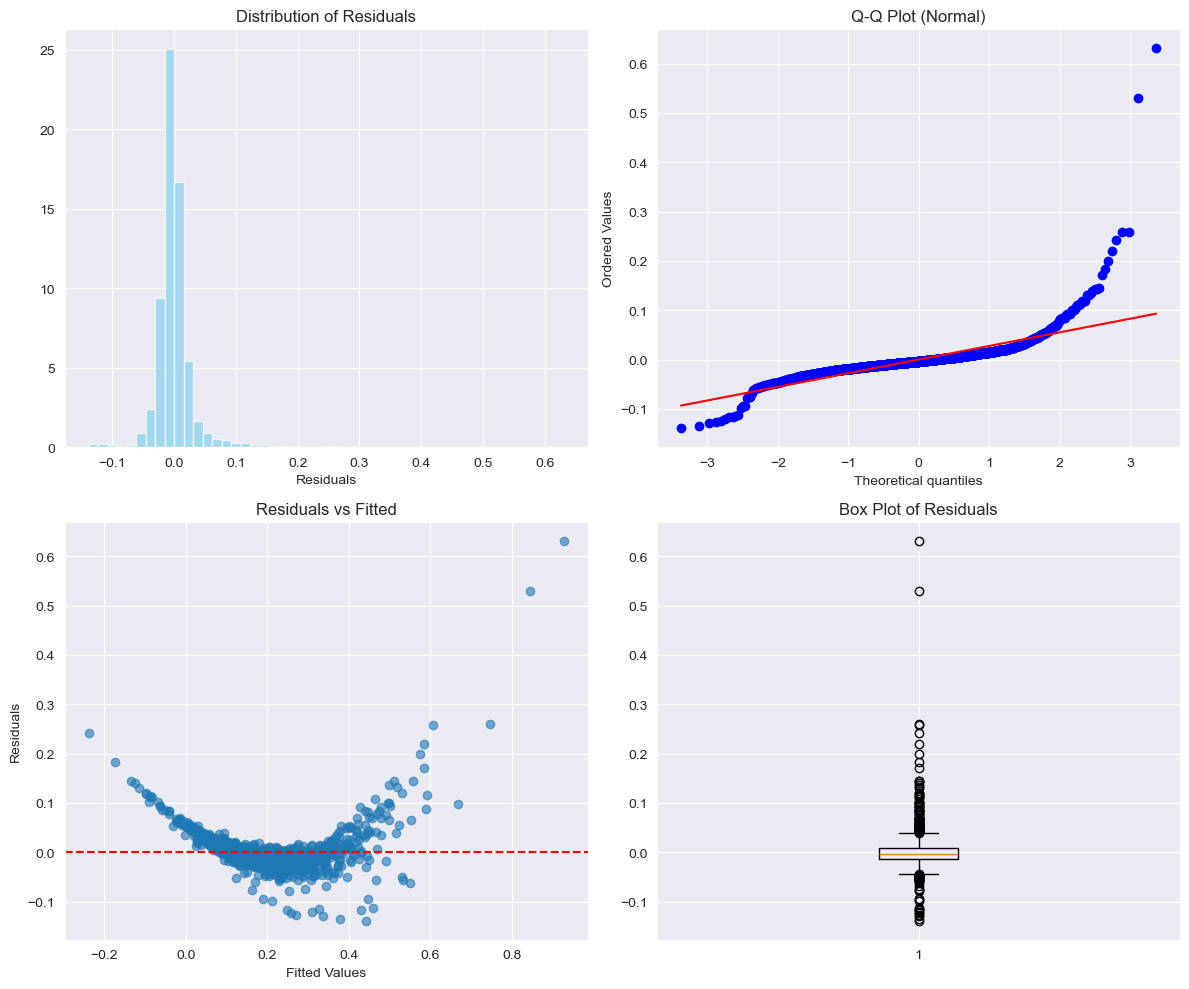

Evaluating bp_stat for: agriculture_forestry_fishing_and_hunting_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


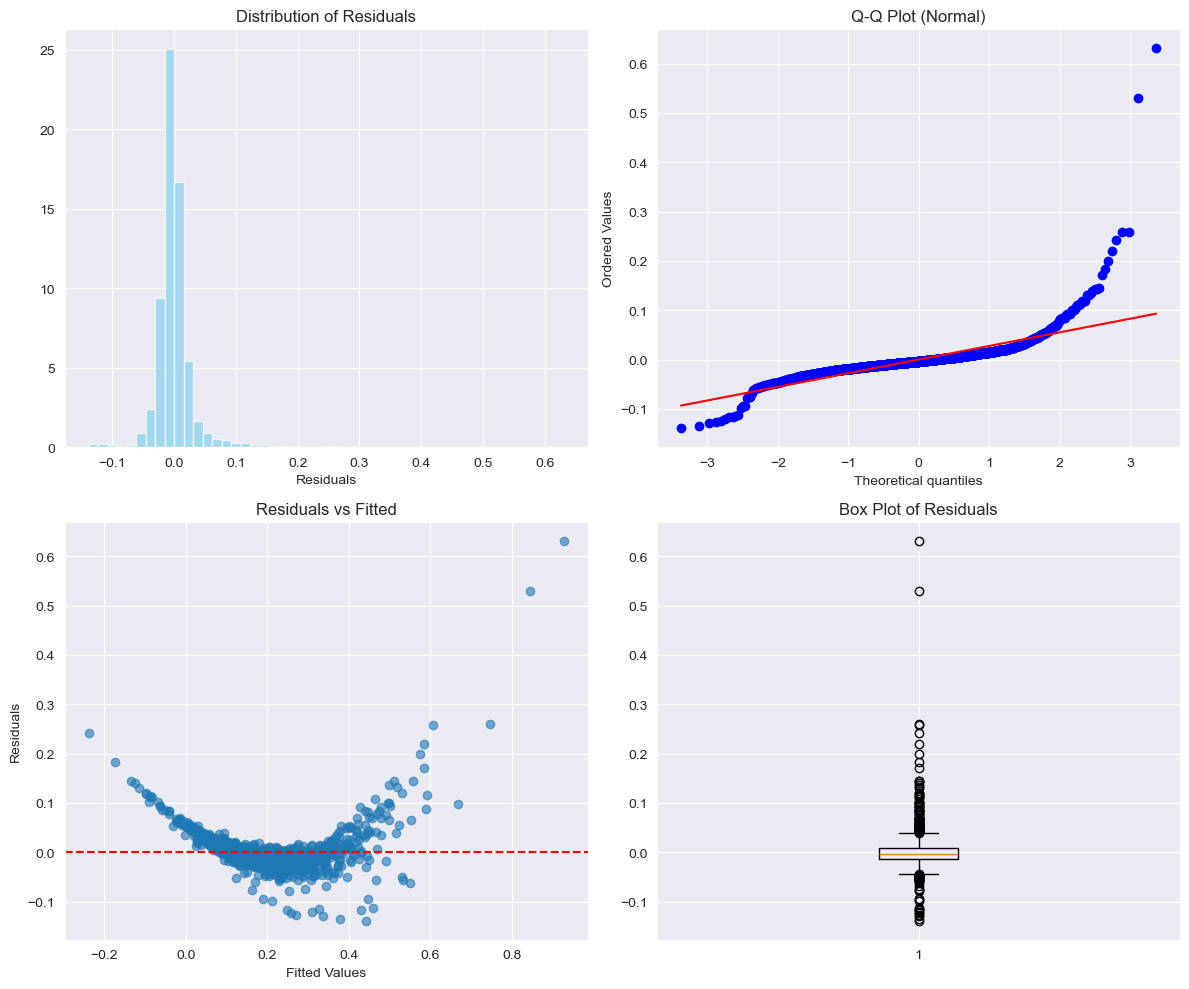

Evaluating bp_stat for: arts_entertainment_and_recreation_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


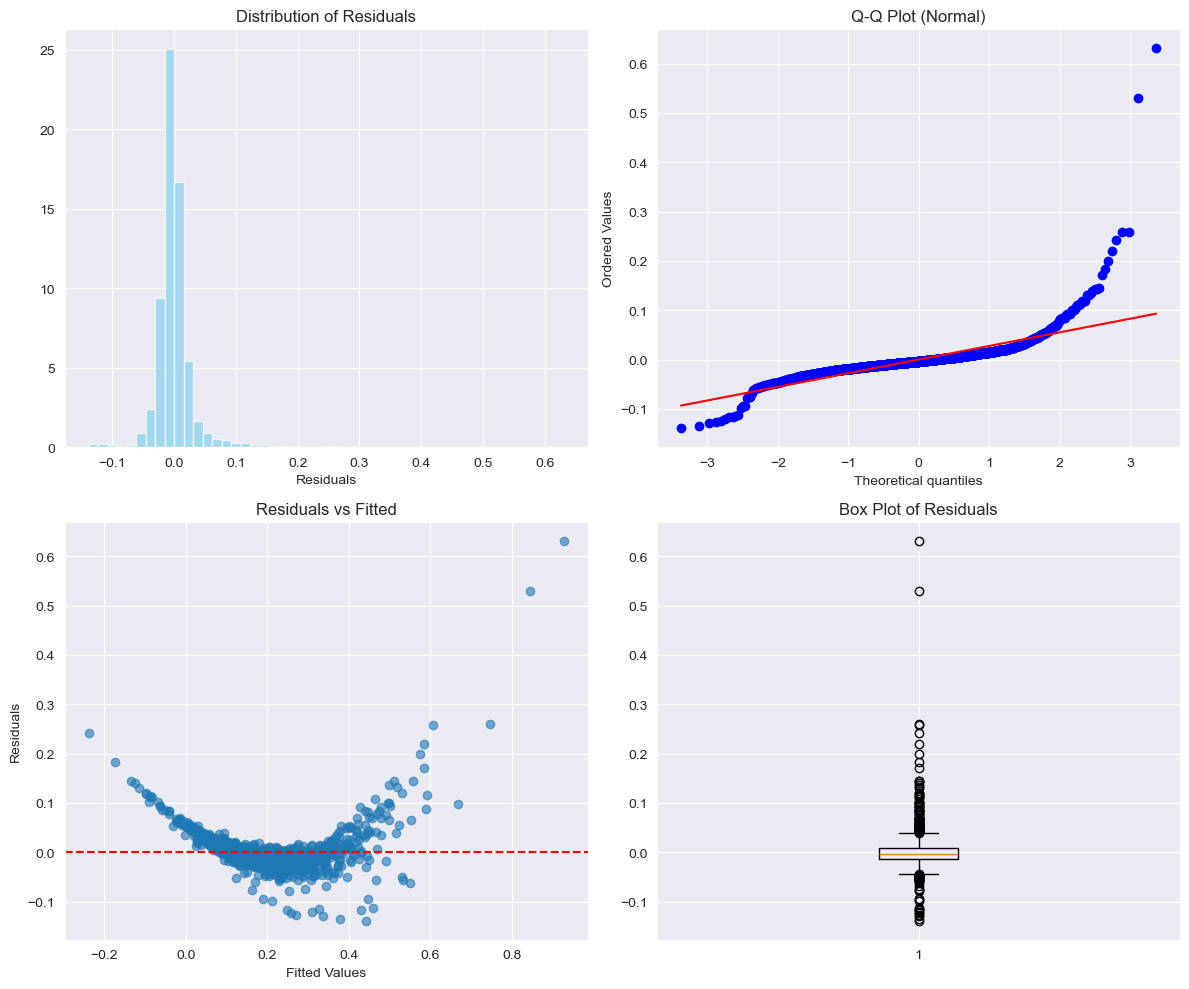

Evaluating bp_stat for: construction_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


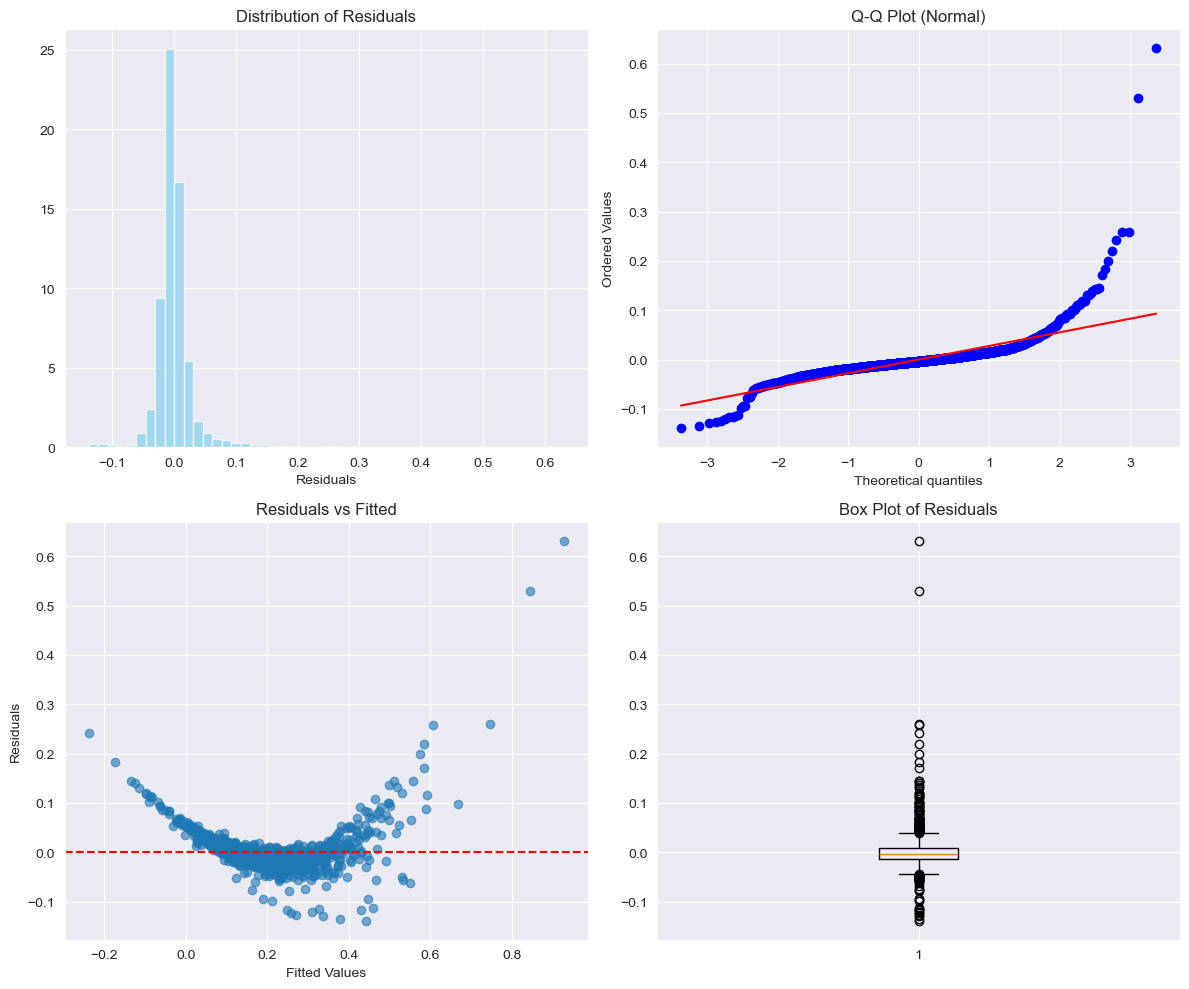

Evaluating bp_stat for: educational_services_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


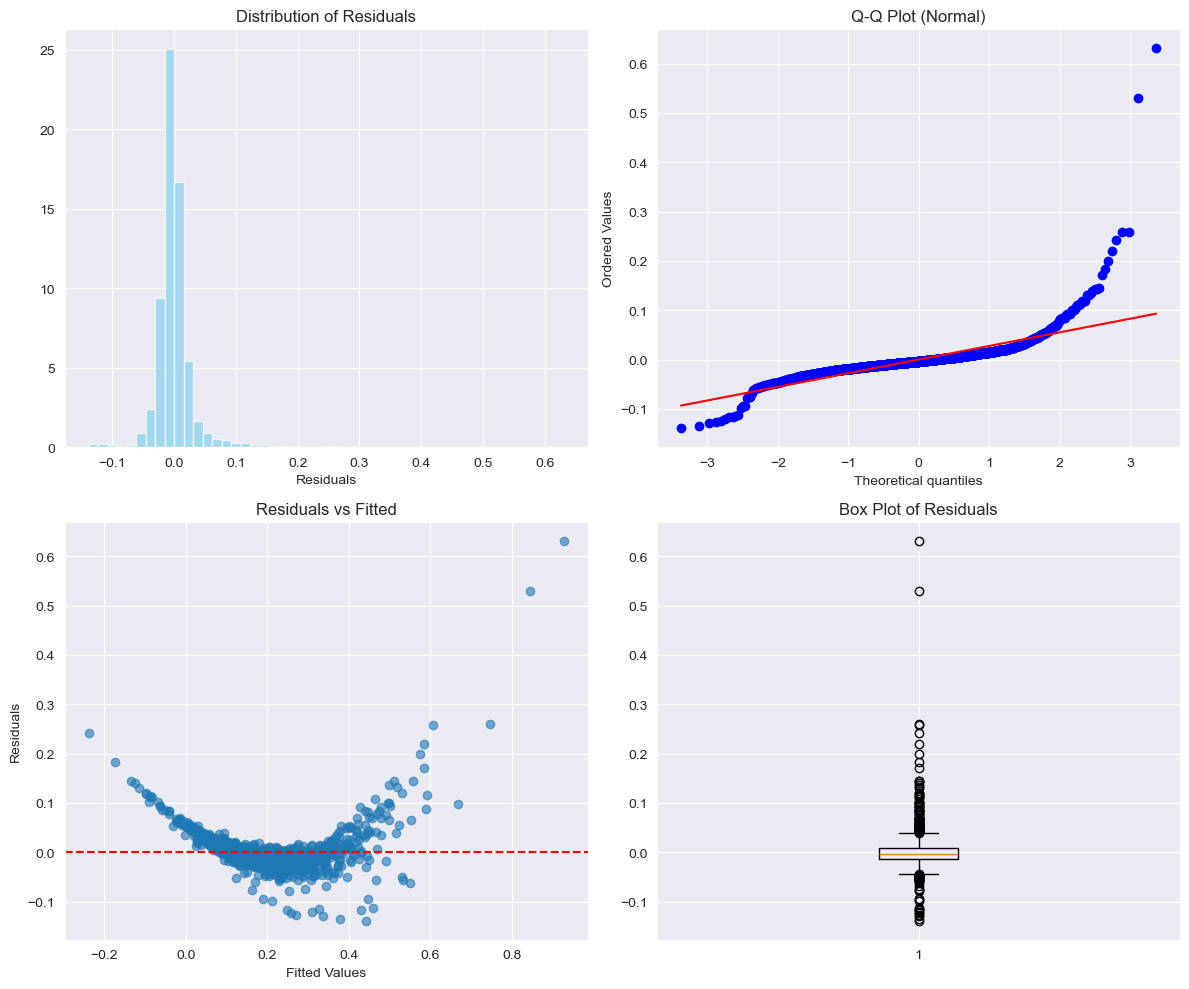

Evaluating bp_stat for: finance_and_insurance_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


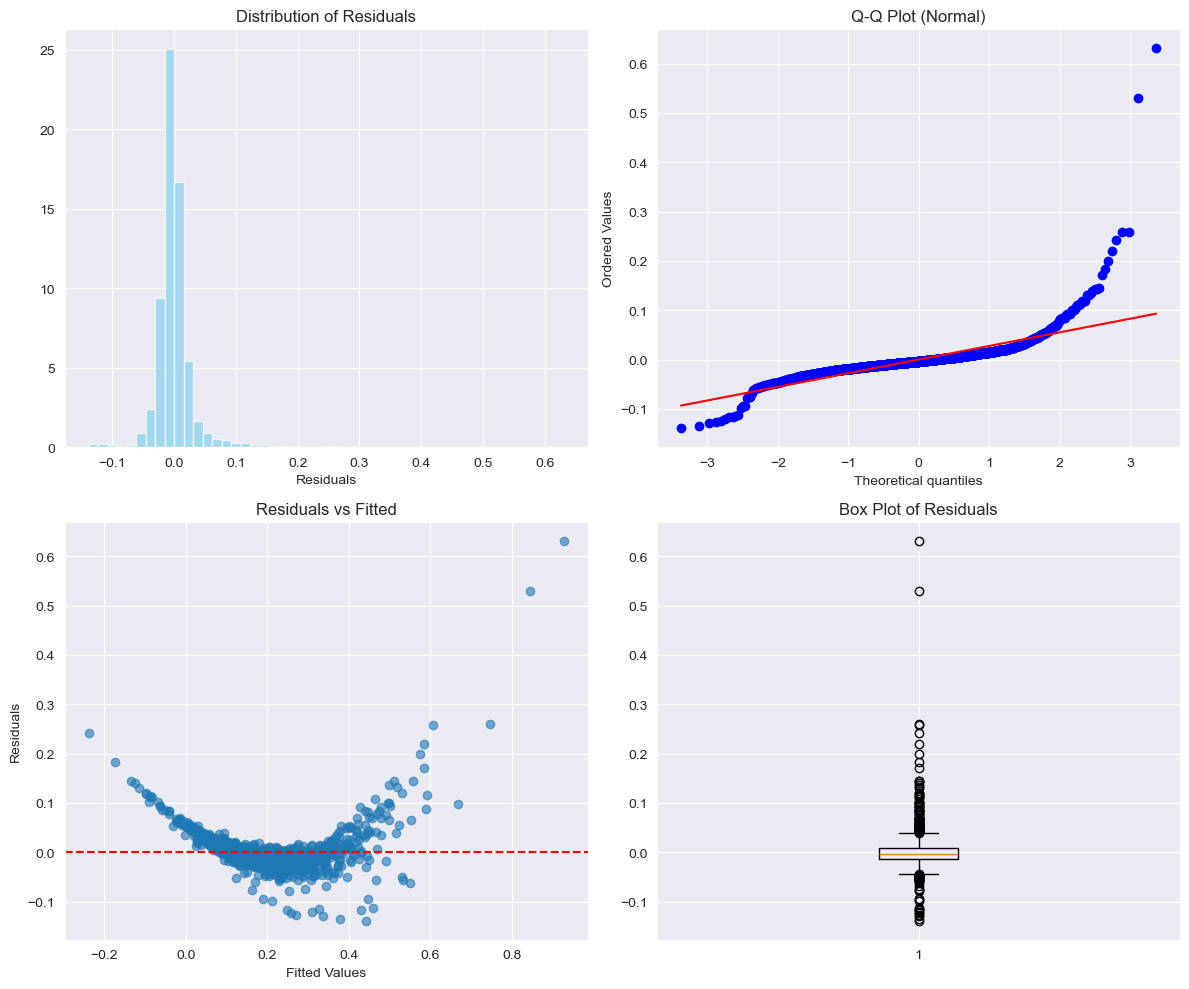

Evaluating bp_stat for: health_care_and_social_assistance_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


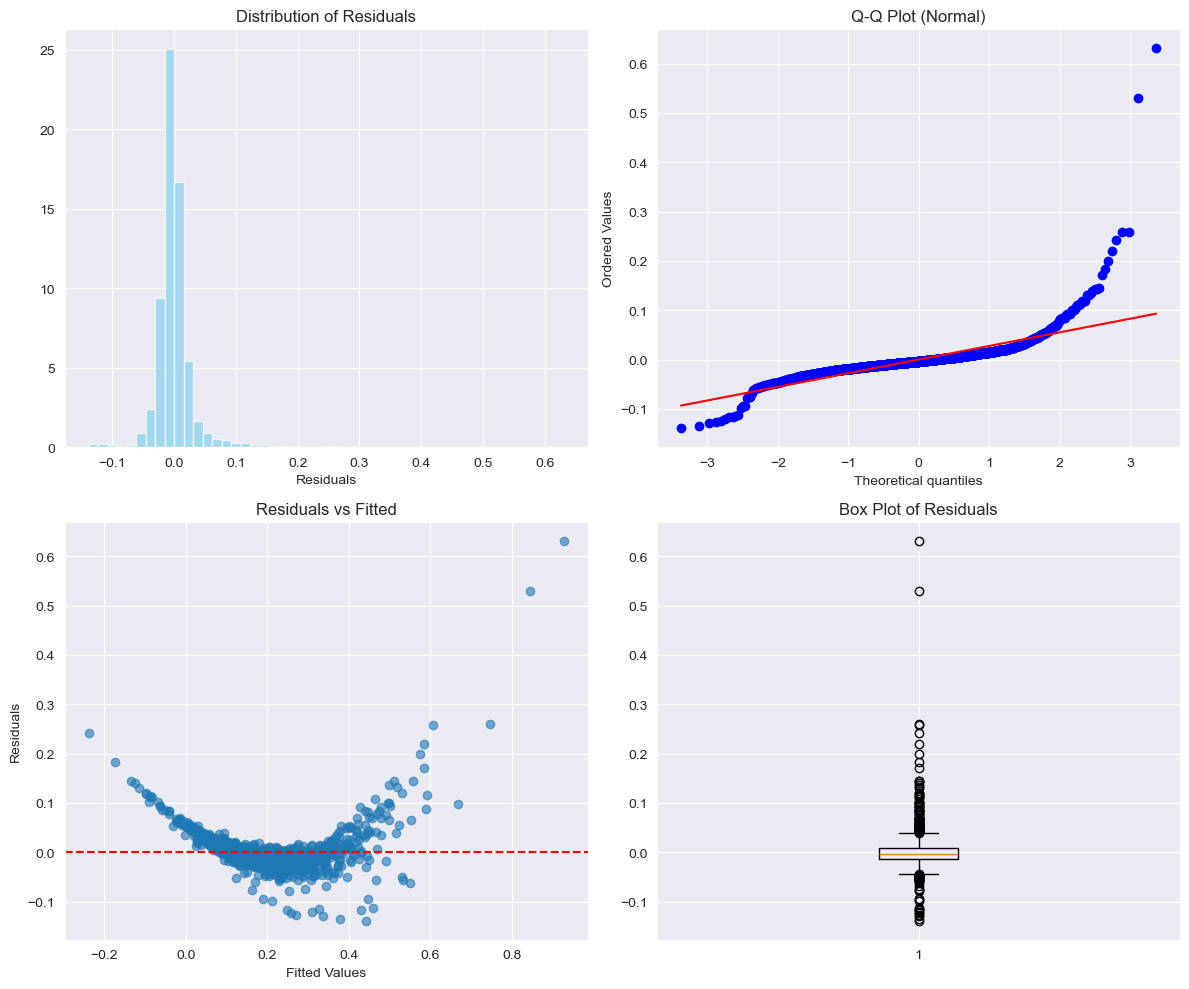

Evaluating bp_stat for: information_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


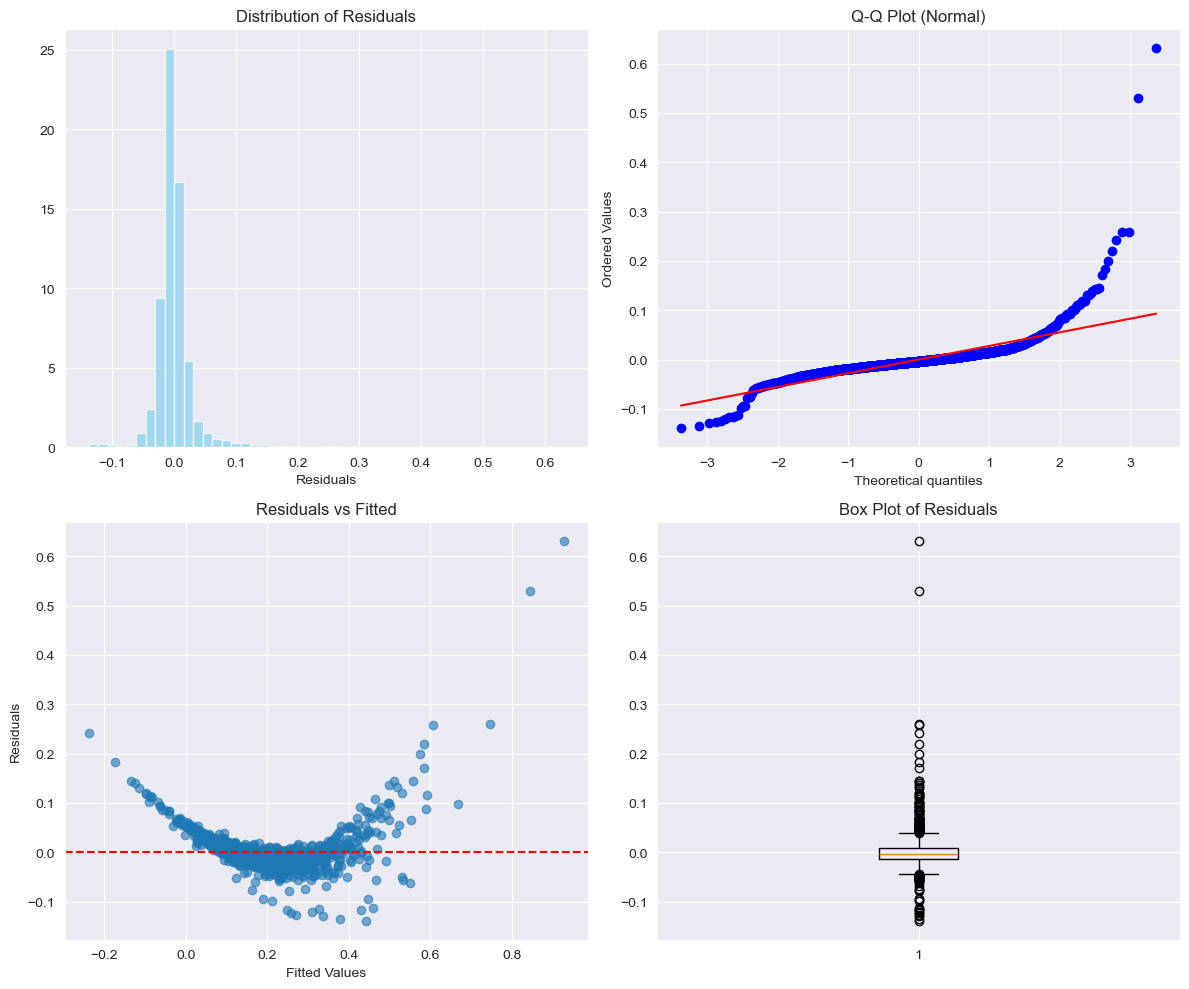

Evaluating bp_stat for: management_of_companies_and_enterprises_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


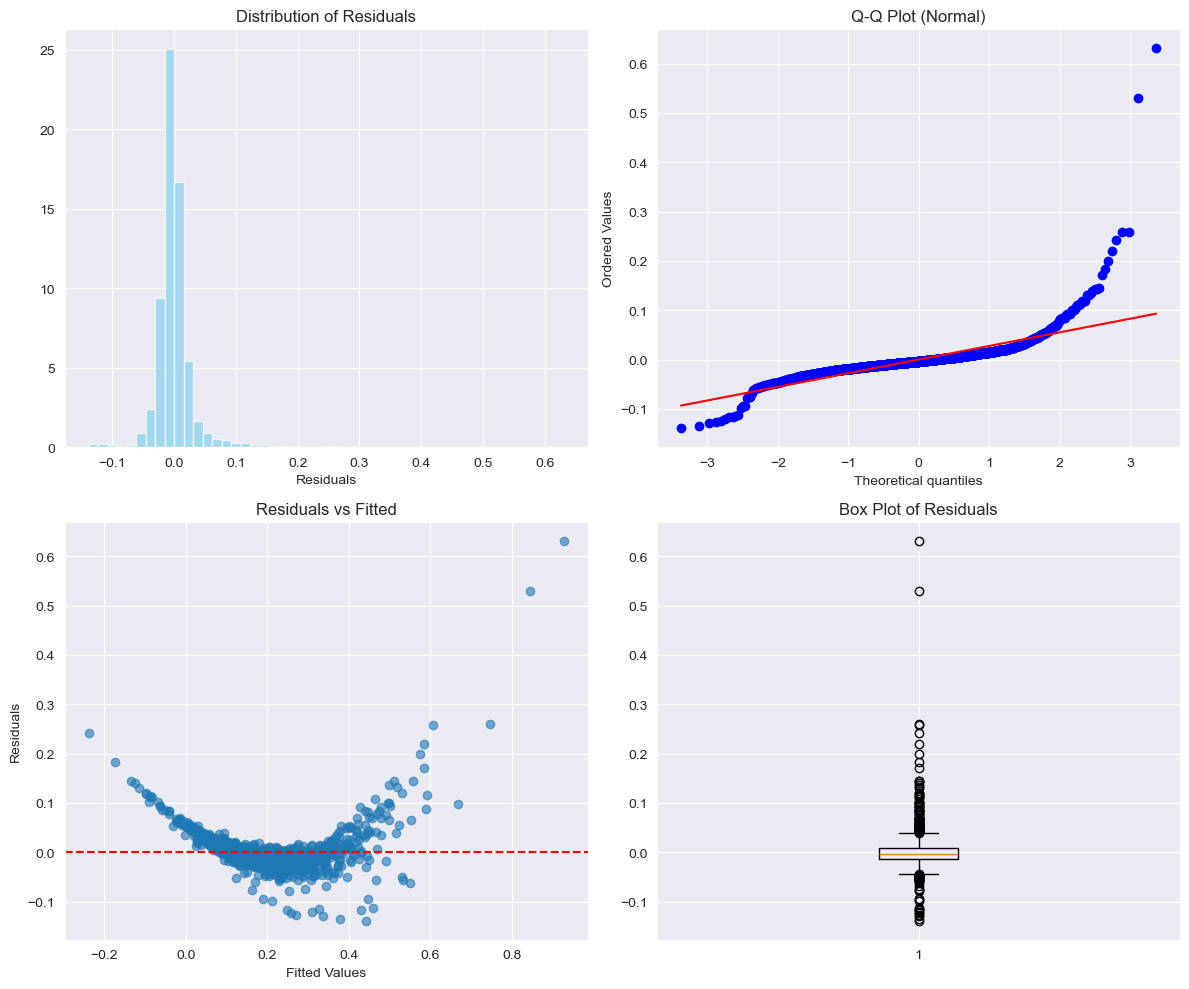

Evaluating bp_stat for: manufacturing_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


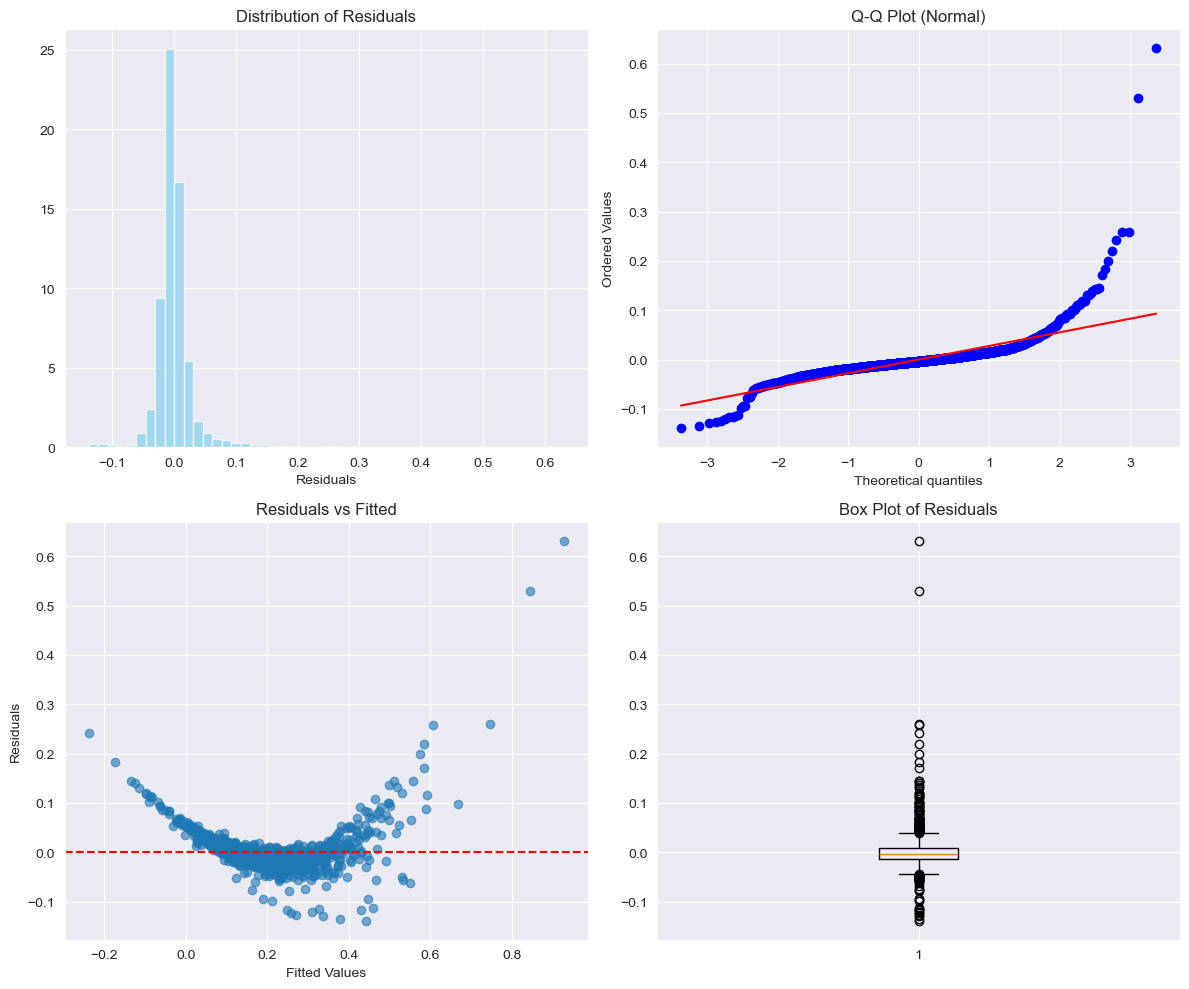

Evaluating bp_stat for: mining_quarrying_and_oil_and_gas_extraction_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


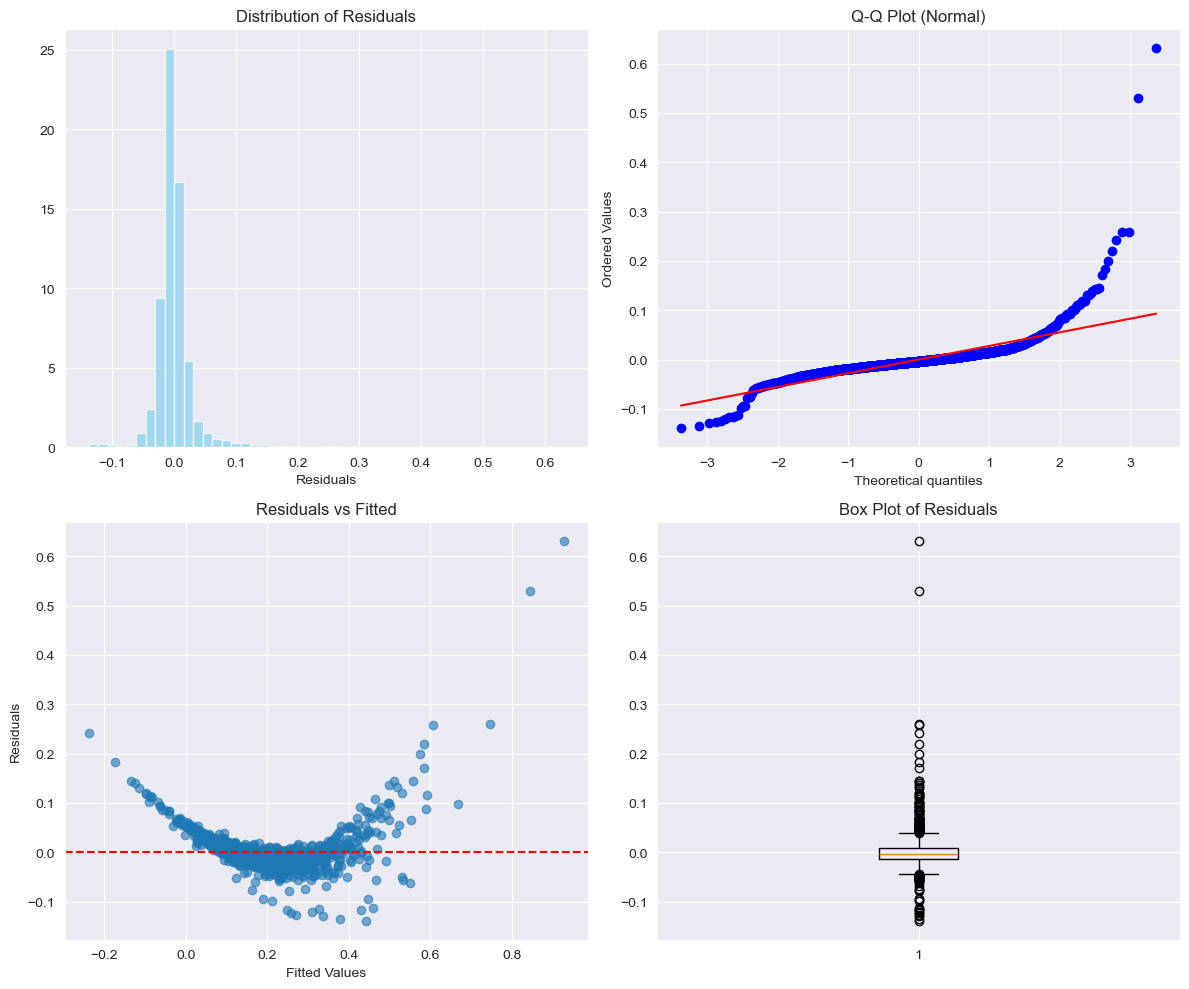

Evaluating bp_stat for: other_services_except_public_administration_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


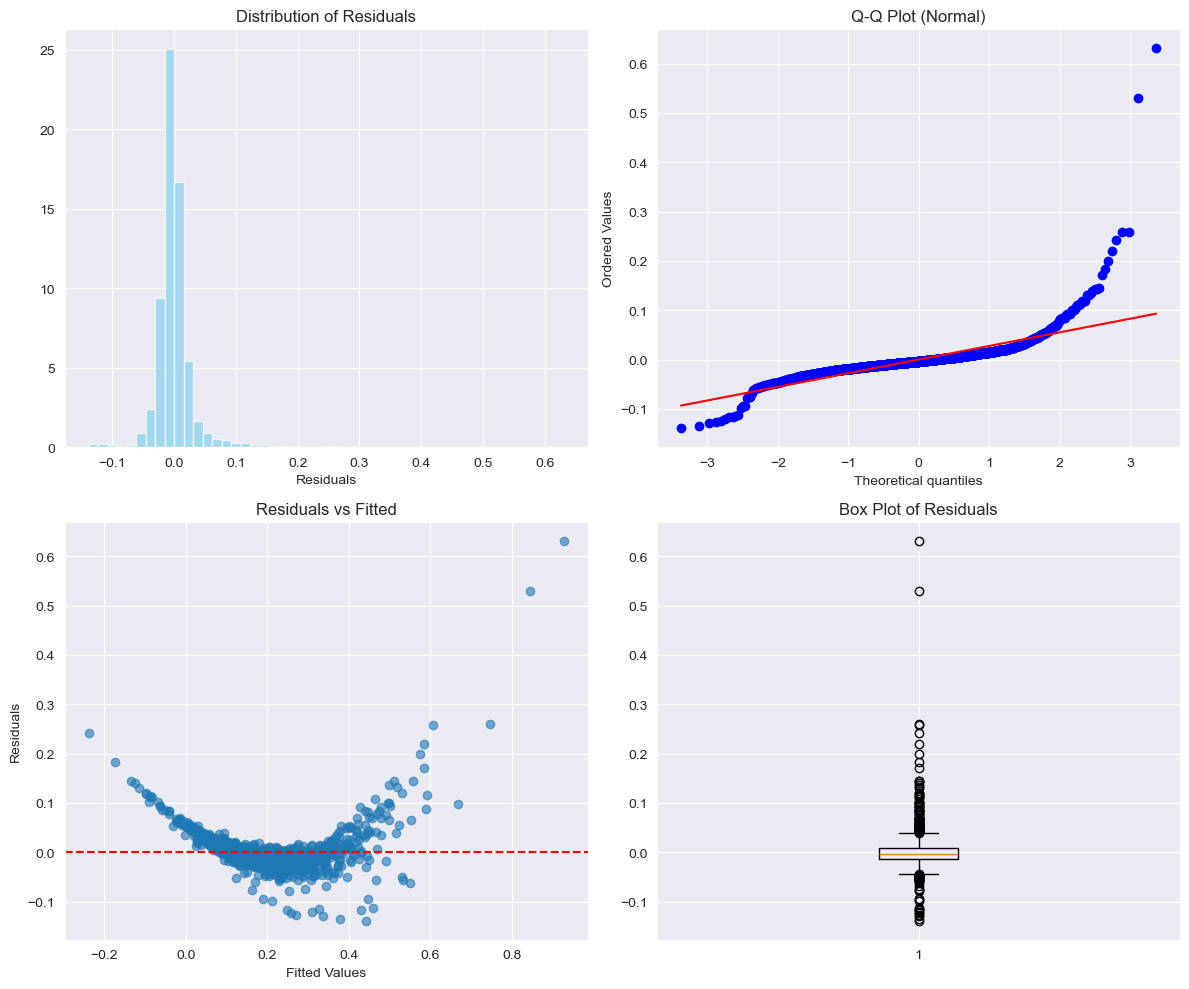

Evaluating bp_stat for: professional_and_technical_services_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


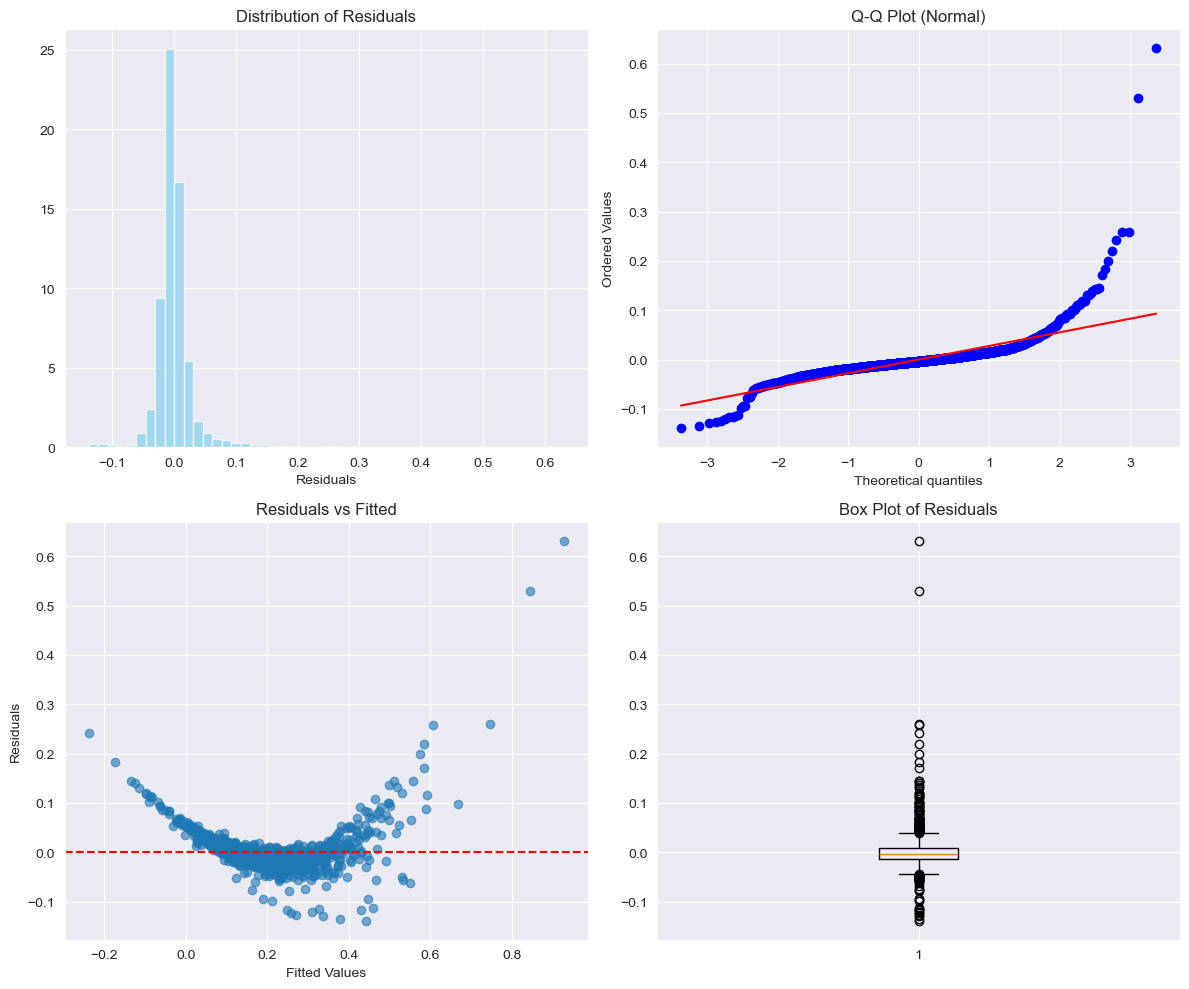

Evaluating bp_stat for: real_estate_and_rental_and_leasing_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


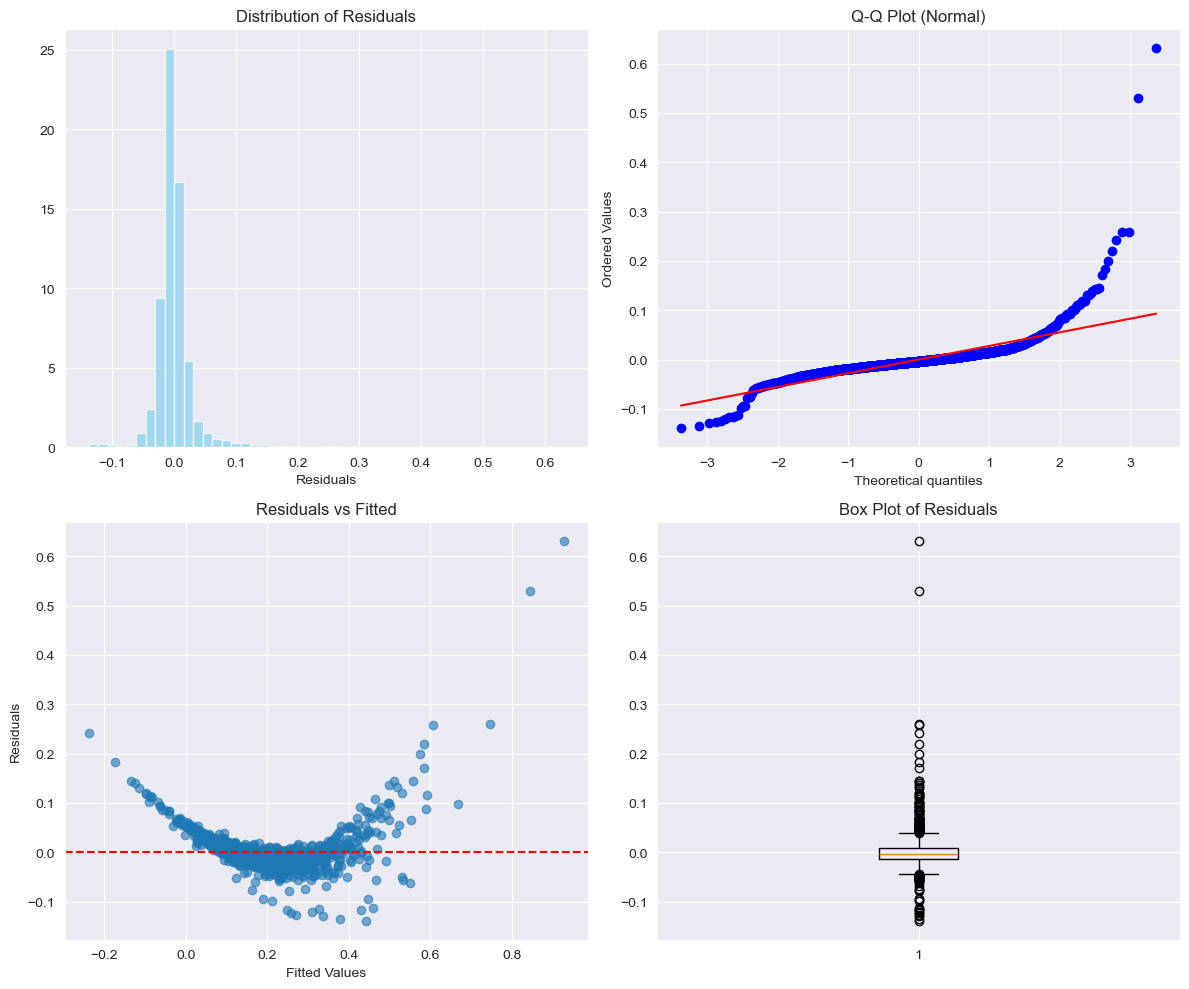

Evaluating bp_stat for: retail_trade_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


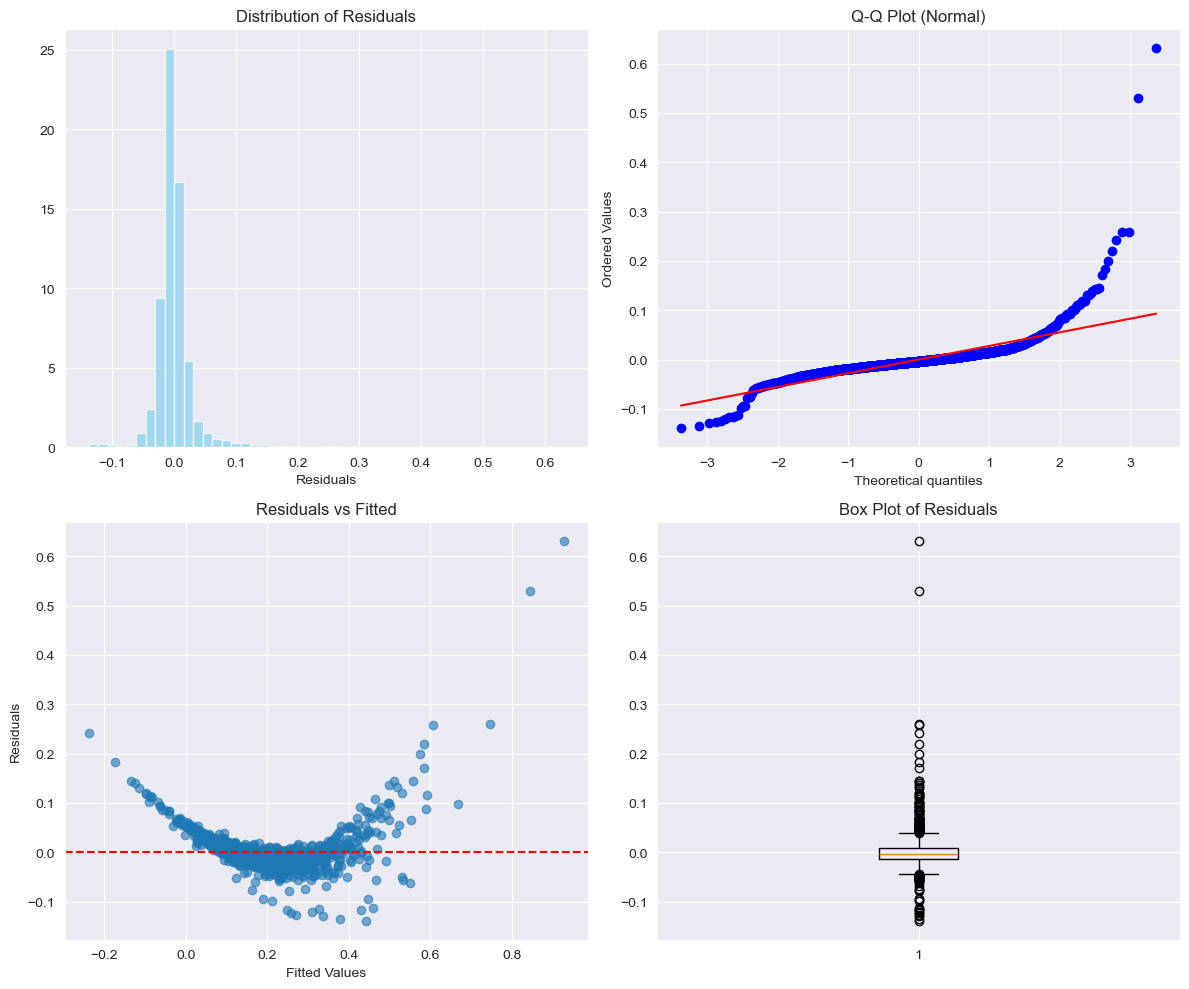

Evaluating bp_stat for: transportation_and_warehousing_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


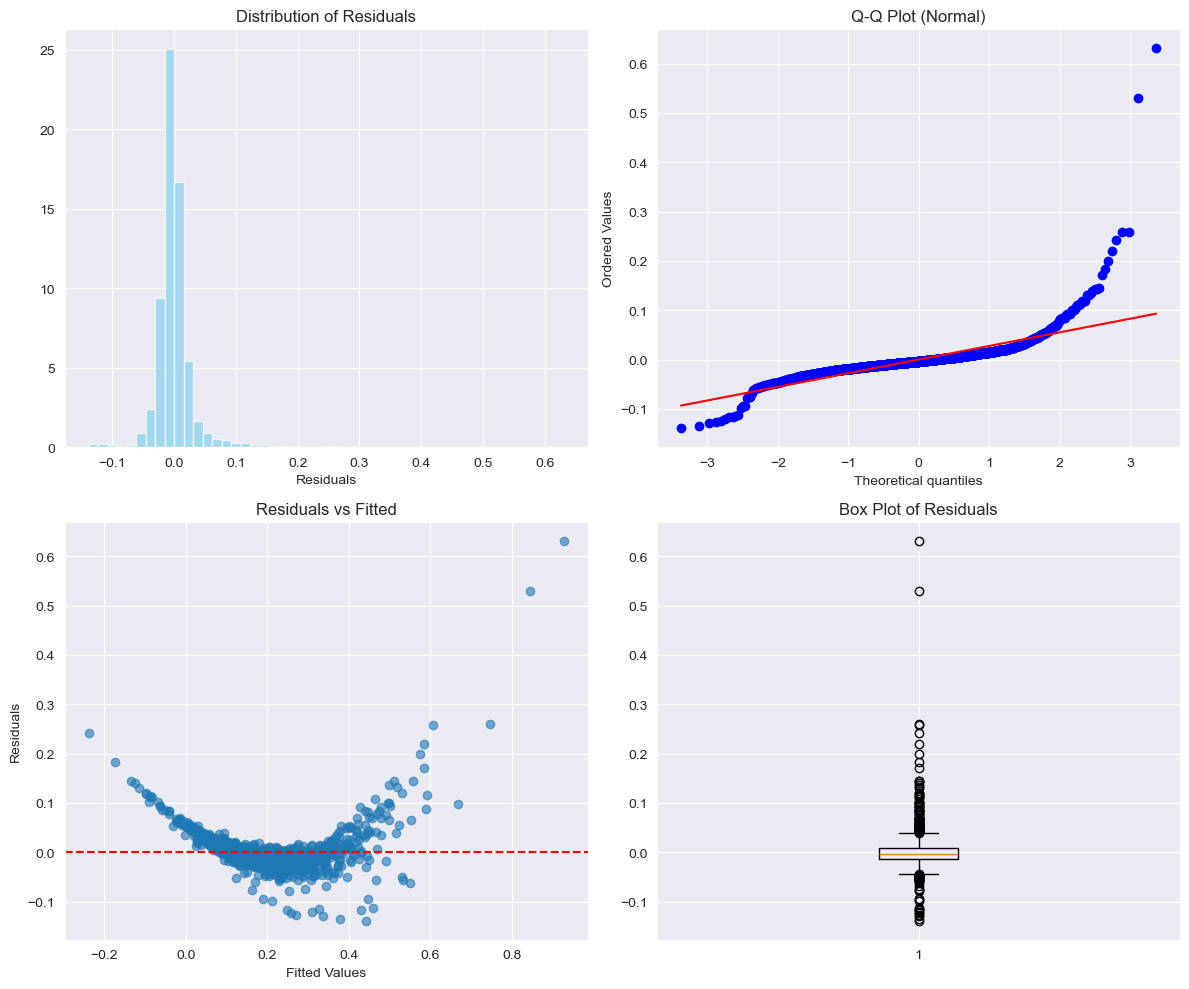

Evaluating bp_stat for: unclassified_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


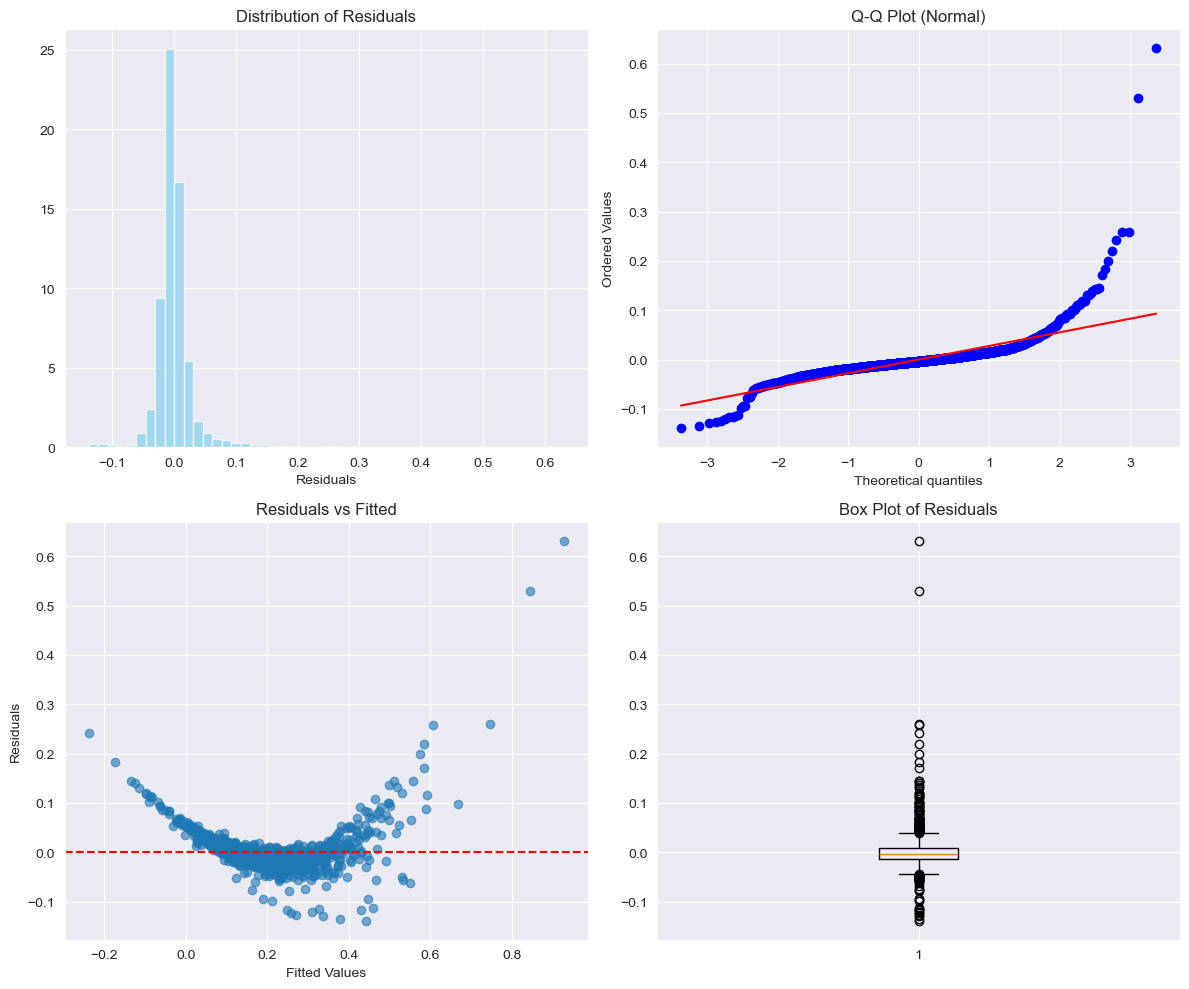

Evaluating bp_stat for: utilities_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


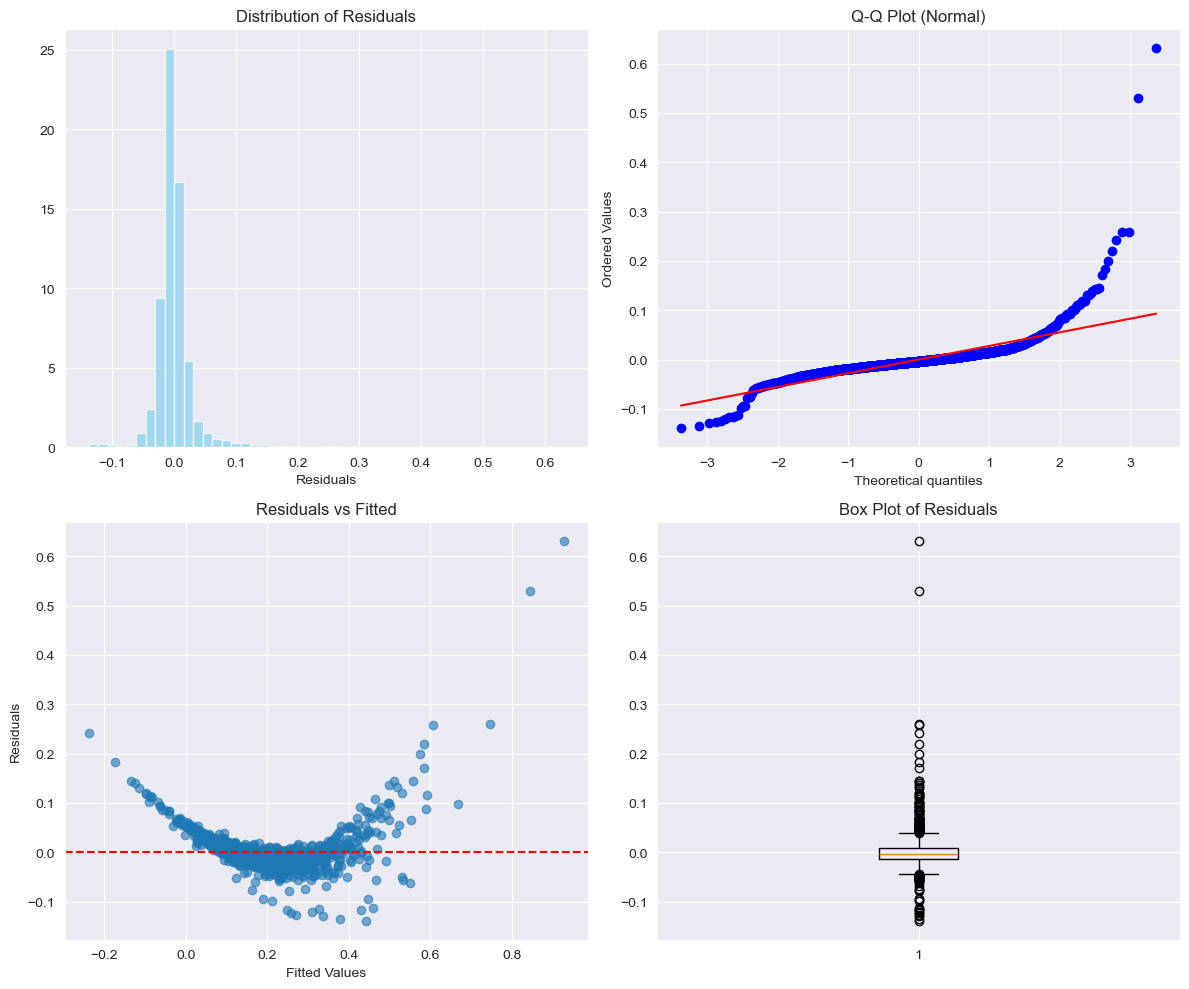

Evaluating bp_stat for: wholesale_trade_wage_share
bp_stat: 359.0501095676743 | bp_pvalue: 3.758801817266958e-59


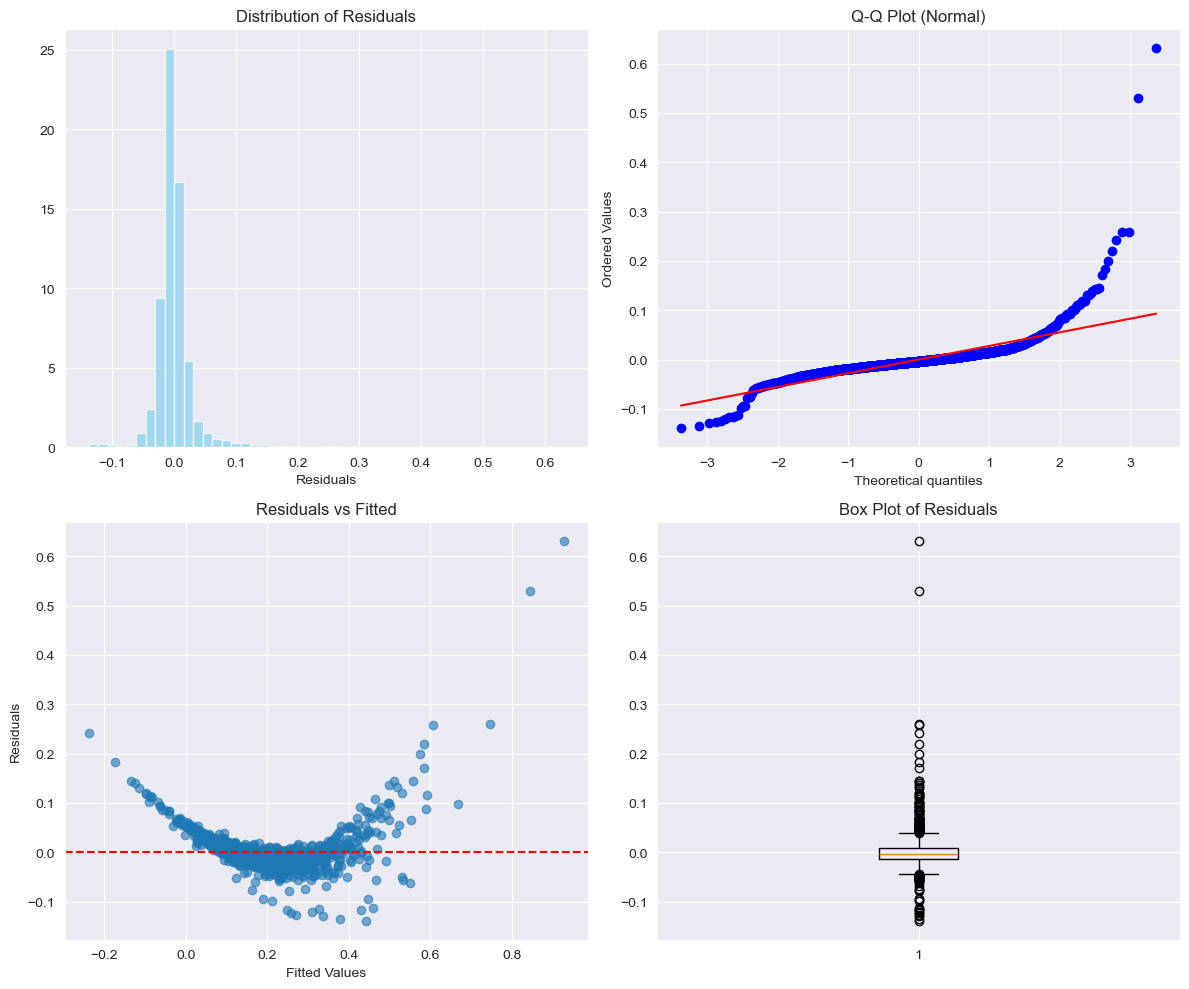

In [9]:
for var in no_loc_df.select_dtypes(include=[np.number]).columns:
    
    if var == target:
        continue
        
    print(f'Evaluating bp_stat for: {var}')
    het_model_spec = {
        'target': target,
        'transform': 'log',
        'data': no_loc_df,
        'exclusion_set': set(no_loc_df.columns) - set([var])
        # 'cat_var_set': set(["C(urbanicity, Treatment(reference='urban'))"])
    }.copy()
    
    het_model_formula = me.generate_formula_string(**het_model_spec)
    het_model = smf.ols(het_model_formula, data=df).fit(cov_type='HC3')
    
    me.test_model_assumptions(het_model)

## Test robust model

Makes heteroscedacity worse. Return to HC3 or transformations to approach more normal residuals. 

bp_stat: 477.61825203345177 | bp_pvalue: 4.6231360407293524e-82


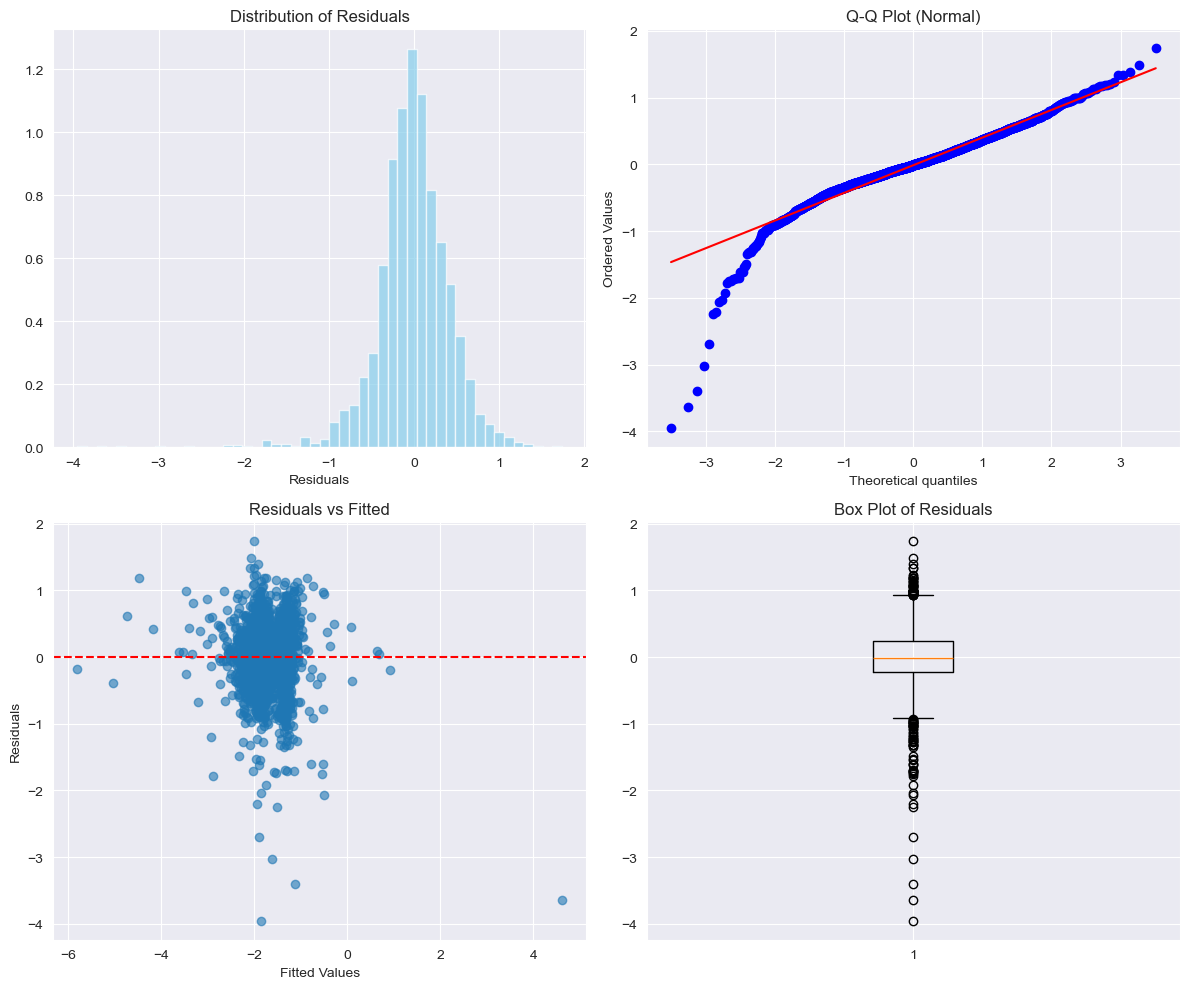

In [10]:
robust_model = smf.rlm(formula=m_col_formula, data=no_loc_df).fit()
robust_model.summary()
me.test_model_assumptions(robust_model)